In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Additional libraries added for project:
import matplotlib.pyplot as plt
import seaborn as sns

#Data processing
from sklearn.impute import KNNImputer

#Model selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

#ML algorthms
from xgboost import XGBRegressor

#Deep learning
import tensorflow as tf

#other
from IPython.display import Image, display

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<h2>Project Scope</h2>

   <ul>
            <li>Using solar generation and associated temperature data to explore time series forecasting and make a short-term solar power forecasting model.</li>
            <li>Examine and process outliers/missing data</li>
            <li>Compare the performance of an XGBoost model vs a deep learning LSTM model to make day-ahead forecasts</li>
            <li>See what impact including the weather data has on the forecast</li>
            <li>Experiment with feature engineering and test how differernt features effect the model's performance</li>
            <li>Make a full pipeline of the best model.</li> 
            <li>Report conclusions and comment on possible project extensions</li>
   </ul>

<h2>Loading and exploring data</h2>
This data was taken from two solar plants in India over the course of 34 days in 15 minute intervals. The weather data is on the plant level (just measured from one sensor) and the generation data is gathered from individual inverters across the plant. More information can be found here: 
<a href="https://www.kaggle.com/datasets/anikannal/solar-power-generation-data">Data Card</a>. Credit to 
<a href="https://www.kaggle.com/anikannal">Ani Kannal</a> for uploading this dataset to Kaggle. 

### Generation data
For now we'll just look at the Plant 1 data.

In [3]:
df_plt1_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')

df_plt1_gen.sample(10, random_state=1)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
32384,31-05-2020 15:30,4135001,pkci93gMrogZuBj,3142.571429,308.771429,5405.285714,7294281.286
58525,13-06-2020 02:45,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7328550.000
26110,28-05-2020 07:45,4135001,McdE0feGgRqW7Ca,4259.857143,418.400000,308.142857,7256697.143
17618,24-05-2020 05:30,4135001,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7093026.000
3631,16-05-2020 21:00,4135001,YxYtjZvoooNbGkE,0.000000,0.000000,6475.000000,7192732.000
39654,04-06-2020 02:45,4135001,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7174627.000
22786,26-05-2020 16:45,4135001,iCRJl6heRkivqQ3,6204.142857,607.871429,7617.571429,7267747.571
43162,05-06-2020 19:30,4135001,zBIq5rxdHJRwDNY,0.000000,0.000000,7723.000000,6500302.000
11802,21-05-2020 08:00,4135001,WRmjgnKYAwPKWDb,5096.400000,499.640000,405.000000,7070130.000
52279,10-06-2020 04:00,4135001,1IF53ai7Xc0U56Y,0.000000,0.000000,0.000000,6380022.000


PLANT_ID is the same throughout, so it can be safely removed. The generation is 0 for nighttime, which of course makes sense for solar power. Also, let's rename to inverters/inverter column to make them easier to track

In [4]:
#Since we're focusing on plant 1 for now we'll shorten the name
df_gen = df_plt1_gen.drop('PLANT_ID', axis=1)

df_gen['INVERTER'] = df_gen.SOURCE_KEY.map({df_gen.SOURCE_KEY.unique()[i-1]: f'INVERTER_{i}' for i in range(1, len(df_gen.SOURCE_KEY.unique()) +1)})
df_gen = df_gen.drop('SOURCE_KEY', axis=1)
inverters = df_gen.INVERTER.unique()
inverters

array(['INVERTER_1', 'INVERTER_2', 'INVERTER_3', 'INVERTER_4',
       'INVERTER_5', 'INVERTER_6', 'INVERTER_7', 'INVERTER_8',
       'INVERTER_9', 'INVERTER_10', 'INVERTER_11', 'INVERTER_12',
       'INVERTER_13', 'INVERTER_14', 'INVERTER_15', 'INVERTER_16',
       'INVERTER_17', 'INVERTER_18', 'INVERTER_19', 'INVERTER_20',
       'INVERTER_21', 'INVERTER_22'], dtype=object)

In [5]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   DC_POWER     68778 non-null  float64
 2   AC_POWER     68778 non-null  float64
 3   DAILY_YIELD  68778 non-null  float64
 4   TOTAL_YIELD  68778 non-null  float64
 5   INVERTER     68778 non-null  object 
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


In [6]:
df_gen.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DATE_TIME,68778,3158,01-06-2020 12:45,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DC_POWER,68778.0,NaN,NaN,NaN,3147.426211,4036.457169,0.0,0.0,429.0,6366.964286,14471.125
AC_POWER,68778.0,NaN,NaN,NaN,307.802752,394.396439,0.0,0.0,41.49375,623.61875,1410.95
DAILY_YIELD,68778.0,NaN,NaN,NaN,3295.968737,3145.178309,0.0,0.0,2658.714286,6274.0,9163.0
TOTAL_YIELD,68778.0,NaN,NaN,NaN,6978711.760671,416271.982856,6183645.0,6512002.53575,7146685.0,7268705.90625,7846821.0
INVERTER,68778,22,INVERTER_11,3155,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_gen.groupby('INVERTER').count().DATE_TIME.sort_values()

INVERTER
INVERTER_22    3104
INVERTER_7     3118
INVERTER_3     3118
INVERTER_10    3119
INVERTER_2     3119
INVERTER_20    3119
INVERTER_9     3123
INVERTER_5     3124
INVERTER_15    3124
INVERTER_16    3124
INVERTER_21    3124
INVERTER_12    3125
INVERTER_14    3125
INVERTER_17    3125
INVERTER_19    3126
INVERTER_18    3126
INVERTER_13    3130
INVERTER_8     3130
INVERTER_4     3133
INVERTER_6     3133
INVERTER_1     3154
INVERTER_11    3155
Name: DATE_TIME, dtype: int64

The dtypes make sense, but we'll need to make the DATE_TIME a datetime object for easier analysis. No nulls detected, but it looks like some data is missing. At the plant level we would expect 3264 unique timestamps (34 days * 24 hours * 4 (15 minute intervals in hour)), but there are only 3158. Across all inverters there would be 71808 rows (3264 * 22 (inverters)), but we only have 68778. So overall, around 3000 or ~4% of the total expected timestamps are missing. There is also some variance per inverter for what timestamps are missing as the above inverter row count shows.

In [8]:
df_gen['DATE_TIME'] = pd.to_datetime(df_gen.DATE_TIME, format='%d-%m-%Y %H:%M')
df_gen.dtypes

DATE_TIME      datetime64[ns]
DC_POWER              float64
AC_POWER              float64
DAILY_YIELD           float64
TOTAL_YIELD           float64
INVERTER               object
dtype: object

### Weather sensor data

In [9]:
df_plt1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')

df_plt1_weather.sample(10, random_state=1)

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
1194,2020-05-28 02:30:00,4135001,HmiyD2TTLFNqkNe,22.398088,20.536780,0.000000
2385,2020-06-09 16:45:00,4135001,HmiyD2TTLFNqkNe,29.618705,37.964126,0.302090
99,2020-05-16 03:30:00,4135001,HmiyD2TTLFNqkNe,21.731421,20.351884,0.000000
2779,2020-06-13 19:15:00,4135001,HmiyD2TTLFNqkNe,24.000767,21.948254,0.000000
13,2020-05-15 03:15:00,4135001,HmiyD2TTLFNqkNe,24.985215,24.351508,0.000000
2304,2020-06-08 20:30:00,4135001,HmiyD2TTLFNqkNe,24.091545,20.824284,0.000000
442,2020-05-19 18:00:00,4135001,HmiyD2TTLFNqkNe,25.046377,25.426198,0.001575
2847,2020-06-14 12:15:00,4135001,HmiyD2TTLFNqkNe,24.932560,36.606858,0.472765
45,2020-05-15 11:15:00,4135001,HmiyD2TTLFNqkNe,30.216062,50.006989,0.585787
705,2020-05-22 22:45:00,4135001,HmiyD2TTLFNqkNe,23.214526,21.719092,0.000000


In [10]:
df_plt1_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [11]:
df_plt1_weather.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DATE_TIME,3182,3182,2020-05-15 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLANT_ID,3182.0,NaN,NaN,NaN,4135001.0,0.0,4135001.0,4135001.0,4135001.0,4135001.0,4135001.0
SOURCE_KEY,3182,1,HmiyD2TTLFNqkNe,3182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMBIENT_TEMPERATURE,3182.0,NaN,NaN,NaN,25.531606,3.354856,20.398505,22.705182,24.613814,27.920532,35.252486
MODULE_TEMPERATURE,3182.0,NaN,NaN,NaN,31.091015,12.261222,18.140415,21.090553,24.61806,41.30784,65.545714
IRRADIATION,3182.0,NaN,NaN,NaN,0.228313,0.300836,0.0,0.0,0.024653,0.449588,1.221652


We can remove the PLANT_ID and SOURCE_KEY since they are the same throughout. Let's again make DATE_TIME a datetime object. Based on the DATE_TIME count we also have some missing weather data. 

In [12]:
df_weather = df_plt1_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S') 

### Filling out missing datetimes
In order to fill in the missing datetimes for our generation and weather sensor data set let's make a datetime object with the full range of expected datetimes.

In [13]:
datetimes_full = pd.Series(pd.date_range(df_gen.DATE_TIME.min(), df_gen.DATE_TIME.max(), freq='15min'), name='DATE_TIME')
datetimes_full

0      2020-05-15 00:00:00
1      2020-05-15 00:15:00
2      2020-05-15 00:30:00
3      2020-05-15 00:45:00
4      2020-05-15 01:00:00
               ...        
3259   2020-06-17 22:45:00
3260   2020-06-17 23:00:00
3261   2020-06-17 23:15:00
3262   2020-06-17 23:30:00
3263   2020-06-17 23:45:00
Name: DATE_TIME, Length: 3264, dtype: datetime64[ns]

Now we are ready to merge this will our data sets. Starting with the generation data set: since different inverters have some different datetimes missing we will need to do this one inverter at a time and then concatenate them back together.

In [14]:
dfs_gen = []
for i in inverters:
    df_inverter = df_gen[df_gen.INVERTER == i]
    df_inverter = df_inverter.merge(datetimes_full, on='DATE_TIME', how='right')
    df_inverter['INVERTER'] = i
    dfs_gen.append(df_inverter)
df_gen = pd.concat(dfs_gen)
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 3263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    71808 non-null  datetime64[ns]
 1   DC_POWER     68778 non-null  float64       
 2   AC_POWER     68778 non-null  float64       
 3   DAILY_YIELD  68778 non-null  float64       
 4   TOTAL_YIELD  68778 non-null  float64       
 5   INVERTER     71808 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 3.8+ MB


Now we can add the weather data to this as well to make our full dataframe.

In [15]:
df = df_gen.merge(df_weather, on='DATE_TIME', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 71807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   DC_POWER             68778 non-null  float64       
 2   AC_POWER             68778 non-null  float64       
 3   DAILY_YIELD          68778 non-null  float64       
 4   TOTAL_YIELD          68778 non-null  float64       
 5   INVERTER             71808 non-null  object        
 6   AMBIENT_TEMPERATURE  70004 non-null  float64       
 7   MODULE_TEMPERATURE   70004 non-null  float64       
 8   IRRADIATION          70004 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 5.5+ MB


## Exploratory Data Analysis
To start our more in-depth analysis, we'll can make some basic datetime features. If we were modeling throughout the year(s), month and year could be interesting to account for seasonal variation and long-term trends, but since our data only covers 34 days, we will omit them. We can use dayofyear to capture any longer trends that might be present.

In [16]:
df['HOUR'] = df.DATE_TIME.dt.hour
df['DAY'] = df.DATE_TIME.dt.dayofyear
df['DAY_WEEK'] = df.DATE_TIME.dt.dayofweek
df['MINUTES_15'] = df.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df['MINUTES_15'] = df.MINUTES_15.map({df.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df['DAY'] = df.DAY.map({df.DAY.unique()[i-1]:i for i in range(1, 35)})

Let's check on the linear correlation of the features.

In [17]:
corr = df.corr(numeric_only=True)
corr

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR,DAY,DAY_WEEK,MINUTES_15
DC_POWER,1.000000,0.999996,0.082284,0.003815,0.724668,0.954811,0.989391,2.410437e-02,-3.053931e-02,1.764947e-02,2.413064e-02
AC_POWER,0.999996,1.000000,0.082234,0.003804,0.724903,0.954924,0.989340,2.410128e-02,-3.047131e-02,1.764008e-02,2.412678e-02
DAILY_YIELD,0.082284,0.082234,1.000000,0.009867,0.478496,0.198308,0.078317,8.361242e-01,-3.013040e-03,2.716671e-02,8.362076e-01
TOTAL_YIELD,0.003815,0.003804,0.009867,1.000000,-0.036150,-0.015596,-0.005490,4.988189e-03,1.728681e-01,-1.818331e-02,4.990603e-03
AMBIENT_TEMPERATURE,0.724668,0.724903,0.478496,-0.036150,1.000000,0.853778,0.722999,3.222789e-01,-2.204906e-01,5.673201e-02,3.219509e-01
MODULE_TEMPERATURE,0.954811,0.954924,0.198308,-0.015596,0.853778,1.000000,0.961566,1.027911e-01,-9.264400e-02,3.505704e-02,1.026066e-01
IRRADIATION,0.989391,0.989340,0.078317,-0.005490,0.722999,0.961566,1.000000,1.580428e-02,-3.039712e-02,2.126718e-02,1.579879e-02
HOUR,0.024104,0.024101,0.836124,0.004988,0.322279,0.102791,0.015804,1.000000e+00,2.607124e-16,-2.829067e-17,9.991858e-01
DAY,-0.030539,-0.030471,-0.003013,0.172868,-0.220491,-0.092644,-0.030397,2.607124e-16,1.000000e+00,-1.034175e-01,9.708847e-17
DAY_WEEK,0.017649,0.017640,0.027167,-0.018183,0.056732,0.035057,0.021267,-2.829067e-17,-1.034175e-01,1.000000e+00,6.468614e-18


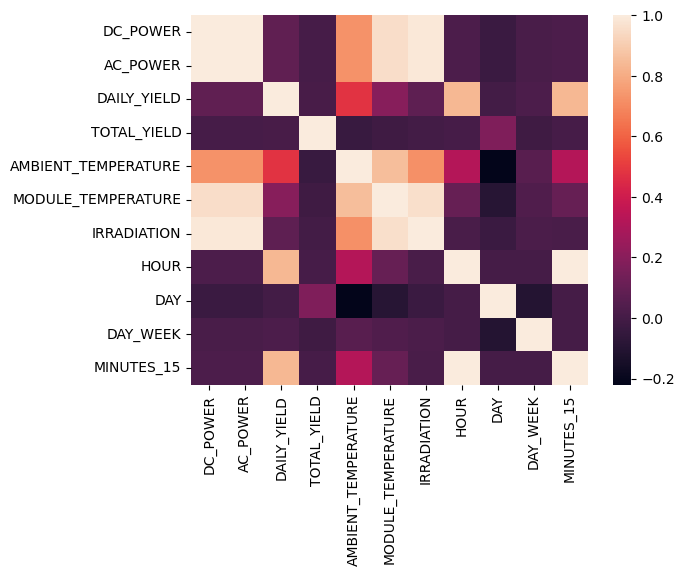

In [18]:
sns.heatmap(corr);

Not surprisingly DC and AC power are highly correlated. This is good! It probably means the inverters in the plant are working correctly to convert the DC to AC. We will ultimately make AC_POWER our target. There is a strong correlation between HOUR and DAILY_YIELD, which makes sense as the daily yield increases throughout the day. For the weather sensor data there is not surprisingly a strong correlation between IRRADIATION and AC_POWER. Also between MODULE_TEMPERATURE and AC_POWER. Now we will look at a pairplot to see another representation of these relationships and look for any non-linear correlations.

In [19]:
# g = sns.PairGrid(df.sample(10000, random_state=1), diag_sharey=False, hue='INVERTER')
# g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.histplot)
#This takes quite a while to run, so saving this figure for future use.
# plt.savefig("gen_pairgrid.png", dpi=400)
# display(Image(filename='gen_pairgrid.png'))

There is A LOT of information to take in here! The zeros dominate the distribution for AC_POWER, DC_POWER and DAILY_YIELD due to the nighttime. As we just saw perviously, there is further evidence of the missing data based on the DAY/MINUTES_15 pair. The inverters start to seperate out based on TOTAL_YIELD and DAILY_YIELD. This suggests the they are operating a different capacities; probably due to any number of factors: age, location within the plant, need for maintaince, etc. Exploring this more is outside the scope of this project, but could be a good starting point for another project. Finally, the connection between HOUR and AC_POWER is interesting and also makes sense with the peaks in the middle of the day. Let's explore this more next and also start to look for outliers.

## Outliers
First a quick check for any negative power numbers.

In [20]:
df[['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']].any() < 0

AC_POWER       False
DC_POWER       False
DAILY_YIELD    False
TOTAL_YIELD    False
dtype: bool

They should only be positive and luckily that appears to be the case.

### Target outliers
Let's now explore our target, AC_POWER. We can define an outlier as \< 1th percentile or \> 99th percentile. To do this I will make four quantile features below: 2 of them in the outlier range and 2 to establish 1 standard deviation from the mean. Then we can plot the results. 

In [21]:
#Making a new dataframe for EDA since we won't necessarily want these features for our model.
df_eda = df.copy()
df_eda = df_eda.merge(df_eda.groupby('MINUTES_15').quantile(0.01, numeric_only=True).AC_POWER.rename('OUTLIERS_LOW_AC_POWER'), on='MINUTES_15', how='left')
df_eda = df_eda.merge(df_eda.groupby('MINUTES_15').quantile(0.99, numeric_only=True).AC_POWER.rename('OUTLIERS_HIGH_AC_POWER'), on='MINUTES_15', how='left')
df_eda = df_eda.merge(df_eda.groupby('MINUTES_15').mean(numeric_only=True).AC_POWER.rename('MEAN'), on='MINUTES_15', how='left')
df_eda = df_eda.merge(df_eda.groupby('MINUTES_15').std(numeric_only=True).AC_POWER.rename('STD'), on='MINUTES_15', how='left')
df_eda['STD_1'] = df_eda.query('AC_POWER < (MEAN + STD) and AC_POWER > (MEAN - STD)').AC_POWER

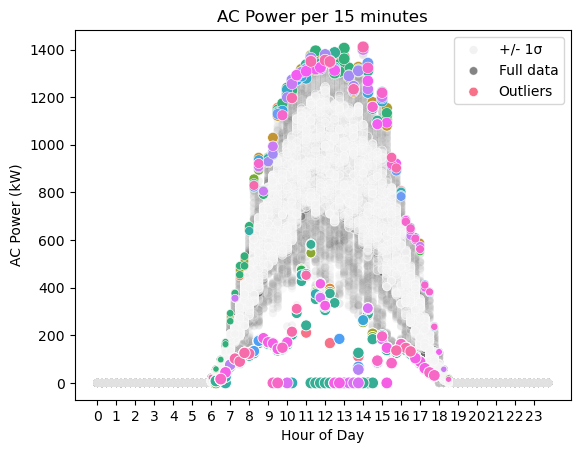

In [22]:
#Since we have nulls in our data now we will exclude those with df[~df.isna()]
fig, ax = plt.subplots()
sns.color_palette("Paired")
sns.scatterplot(data=df_eda[~df_eda.isna()], y='AC_POWER', x='MINUTES_15', hue='INVERTER', palette='gray', alpha=0.05, legend=False)
sns.scatterplot(data=df_eda[~df_eda.isna()], y='STD_1', x='MINUTES_15', hue='INVERTER', palette='gray', alpha =0.5, legend=False)
sns.scatterplot(data=df_eda[~df_eda.isna()].query('AC_POWER > OUTLIERS_HIGH_AC_POWER'), y='AC_POWER', x='MINUTES_15', hue='INVERTER', size='AC_POWER')
sns.scatterplot(data=df_eda[~df_eda.isna()].query('AC_POWER < OUTLIERS_LOW_AC_POWER'), y='AC_POWER', x='MINUTES_15', hue='INVERTER', size= -df_eda[~df_eda.isna()].AC_POWER) 

plt.title('AC Power per 15 minutes')
plt.ylabel('AC Power (kW)')
plt.xlabel('Hour of Day')
ax.set_xticks([i for i in range(1, 97, 4)])
ax.set_xticklabels([i for i in range(24)])
ax.legend(['+/- 1\u03C3','Full data', 'Outliers']);

Interestingly, it looks like there are several instances where the power generated during the middle of the day was 0. This could either indicate bad data, malfunctioning invererters, some kind of planned maintence, really cloudy days, really sunny days where the plant is overheating/at capacity or any number of other things. Without having a deeper domain knowledge it is hard to know for sure, but let's see if we can find any pattern to these mid-day outliers.

First, we'll check to see if any inverters in particular are responsible.

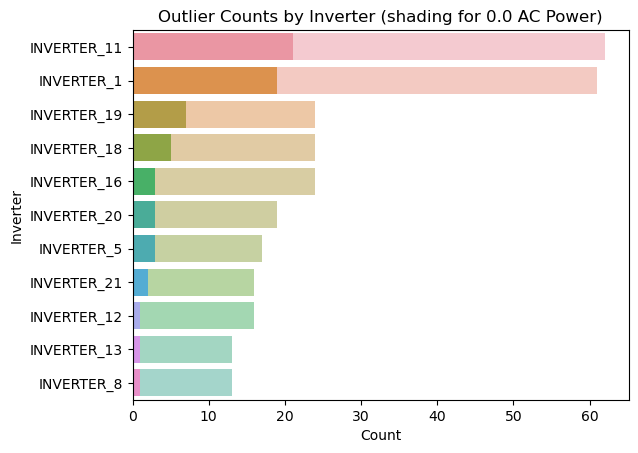

In [23]:
outliers_low = df_eda[~df_eda.isna()].query('AC_POWER < OUTLIERS_LOW_AC_POWER')
outliers_high = df_eda[~df_eda.isna()].query('AC_POWER > OUTLIERS_HIGH_AC_POWER')

outliers_source_low = outliers_low.groupby('INVERTER').count().DATE_TIME.reset_index().sort_values('DATE_TIME', ascending=False)
outliers_source_low_zero = outliers_low[outliers_low.AC_POWER == 0].groupby('INVERTER').count().DATE_TIME.reset_index().sort_values('DATE_TIME', ascending=False)
fig, ax = plt.subplots()
sns.barplot(data = outliers_source_low, y='INVERTER', x='DATE_TIME', alpha = 0.5, )
sns.barplot(data = outliers_source_low_zero, y='INVERTER', x='DATE_TIME')
plt.title('Outlier Counts by Inverter (shading for 0.0 AC Power)')
plt.ylabel('Inverter')
plt.xlabel('Count');

The spread of outlier counts, including the 0.0 AC_POWER measurements are concentrated in inverters 11 and 1. It could be that these were offline for an extended period due to maintance or malfunction. Below we'll look at the spread of the outliers over the course of the full 34 days to see if there is any regularity.

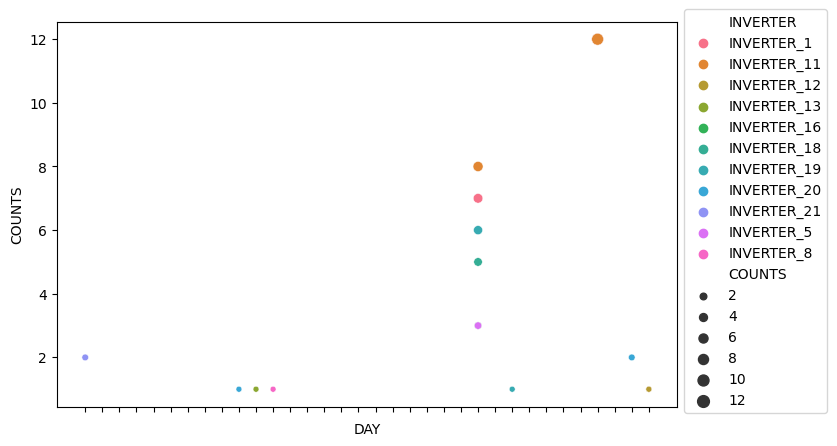

In [24]:
outliers_zero_count = outliers_low[outliers_low.AC_POWER == 0].groupby(['INVERTER','DAY']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
outliers_zero_count
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=outliers_zero_count, x='DAY', y='COUNTS', hue='INVERTER', size='COUNTS', legend='brief')
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_xticks([i for i in range(1,35)]);
ax.set_xticklabels([]);

Several occur on the same day. There could have been maintenance that day or another issue. Now let's check for weekly patterns that could suggest planned maintenance.

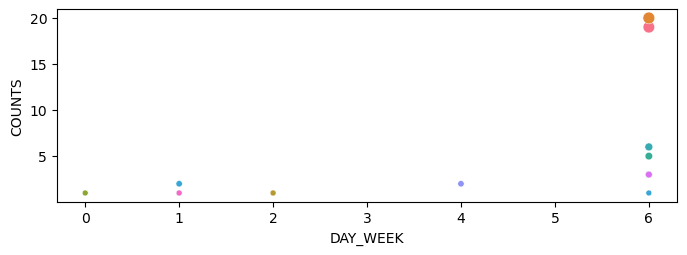

In [25]:
outliers_zero_count = outliers_low[outliers_low.AC_POWER == 0].groupby(['INVERTER','DAY_WEEK']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
outliers_zero_count
fig, ax = plt.subplots(figsize=(8,2.5))
sns.scatterplot(data=outliers_zero_count, x='DAY_WEEK', y='COUNTS', hue='INVERTER', size='COUNTS', legend=False);

Several of the zeros occur on Sunday. This could still be coincidence or it might suggest some scheduled maintance. Since Sunday is likely a day with less demand on the grid, it would make sense to choose that as a day for maintance or some planned outage. Let's circle back and check on the non-zero outliers as well.

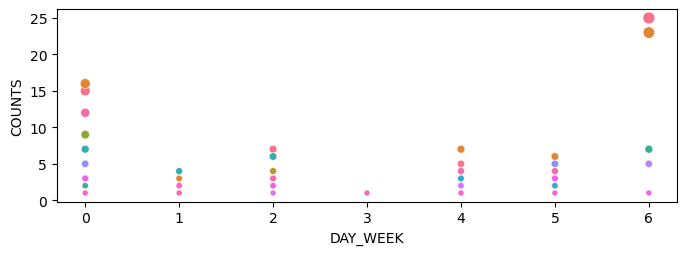

In [26]:
outliers_low_count = outliers_low.groupby(['INVERTER','DAY_WEEK']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
fig, ax = plt.subplots(figsize=(8,2.5))
sns.scatterplot(data=outliers_low_count, x='DAY_WEEK', y='COUNTS', hue='INVERTER', size='COUNTS', legend=False);

There are a greater number of overall outliers on Monday. We might guess that after Sunday maintance there is a delay getting everything back online that goes into Monday. I think there is enough evidence now to choose to keep these outliers in our data as it might help the model account for some of this. That being said the number is low enough that it likely won't have too much of an impact.

### Other Outliers
Let's take a quick look at outliers in the other features, before moving to missing data. Since we'll be exploring several different features we can make a function to help streamline the process.

In [27]:
def outliers(df, feature, high_per, low_per, source_key=True):
    df = df.copy()
    df = df.merge(df.groupby('MINUTES_15').quantile(low_per, numeric_only=True)[feature].rename(f'OUTLIERS_LOW_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').quantile(high_per, numeric_only=True)[feature].rename(f'OUTLIERS_HIGH_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').mean(numeric_only=True)[feature].rename(f'MEAN_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').std(numeric_only=True)[feature].rename(f'STD_{feature}'), on='MINUTES_15', how='left')
    df[f'STD_1_{feature}'] = df.query(f'{feature} < (MEAN_{feature} + STD_{feature}) and {feature} > (MEAN_{feature} - STD_{feature})')[feature]
    
    fig, ax = plt.subplots()
    sns.color_palette("Paired")
    if source_key == True:
        sns.scatterplot(data=df, y=feature, x='MINUTES_15', hue='INVERTER', palette='gray', alpha=0.05, legend=False)
        sns.scatterplot(data=df, y=f'STD_1_{feature}', x='MINUTES_15', hue='INVERTER', palette='gray', alpha =0.5, legend=False)
        sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH_{feature}'), y=feature, x='MINUTES_15', hue='INVERTER', size=feature)
        sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW_{feature}'), y=feature, x='MINUTES_15', hue='INVERTER', size= -df[feature]) 
    else:
        sns.scatterplot(data=df, y=feature, x='MINUTES_15', color='gray', alpha=0.05, legend=False)
        sns.scatterplot(data=df, y=f'STD_1_{feature}', x='MINUTES_15', color='gray', alpha =0.5, legend=False)
        sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH_{feature}'), color='blue', y=feature, x='MINUTES_15', size=feature)
        sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW_{feature}'), color='red', y=feature, x='MINUTES_15', size= -df[feature])
        
    plt.title(f'{feature} per 15 minutes')
    plt.ylabel(f'{feature}')
    plt.xlabel('Hour of Day')
    ax.set_xticks([i for i in range(1, 97, 4)])
    ax.set_xticklabels([i for i in range(24)])
    ax.legend(['Full data', '+/- 1\u03C3', 'Outliers']);
    return ax, df

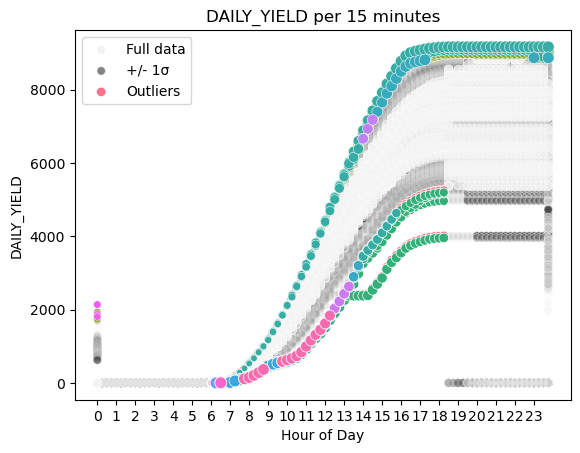

In [28]:
ax_daily_yield, df_daily_yield = outliers(df_eda[~df_eda.isna()], 'DAILY_YIELD', 0.99, 0.01);

There are some unusual things happening here. Mainly the 0s after 6pm. The straight line down at the end of the day and the other line at the start. These seem like they could be incorrect data, or maybe some kind of correction of previous data. Whatever their exact cause, it is probably best to correct these to make the data less disconnected and ultimately help our model. To fix these we'll make every value during the night equal to the maximum daily yield and set all the daily yields at the beginning of the day to 0.

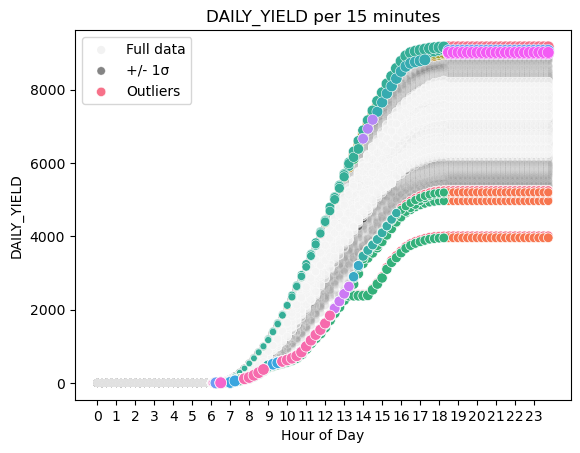

In [29]:
#Had a go through a few trys to settle on MINUTES_15 = 75 as a good starting point for night.
nighttime = [i for i in range(75,97)]
#Making these changes to the original df
df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.HOUR.isin([0]), 0)
#We need a maximun daily yield for each inverter seperately
daily_yield = df.copy()
daily_yield = df.merge(pd.DataFrame({'DAILY_YIELD_DAY_MAX' : df.groupby([ 'INVERTER', 'DAY']).max()['DAILY_YIELD']}).reset_index(), on=['INVERTER', 'DAY'], how='right')
df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.MINUTES_15.isin(nighttime), daily_yield['DAILY_YIELD_DAY_MAX'])

ax_daily_yield, df_daily_yield = outliers(df[~df.isna()], 'DAILY_YIELD', 0.99, 0.01);

This is better now. It remains to be seen how much of an inpact daily yield has on our model, but this should help at least a little.

## Imputing missing values
Now we are ready to impute the missing values as a final step before beginning our modeling. First, let's find a section of missing data to use as a test case of how effective our imputer is.

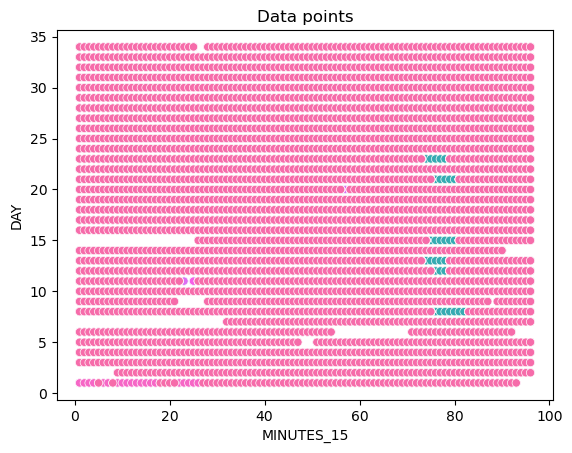

In [30]:
sns.scatterplot(data=df[~df.AC_POWER.isna()], x='MINUTES_15', y='DAY', hue='INVERTER', legend=False)
plt.title('Data points');

There is a fair bit of missing data on day 6, so we can use this day to test our imputer with a before and after plot

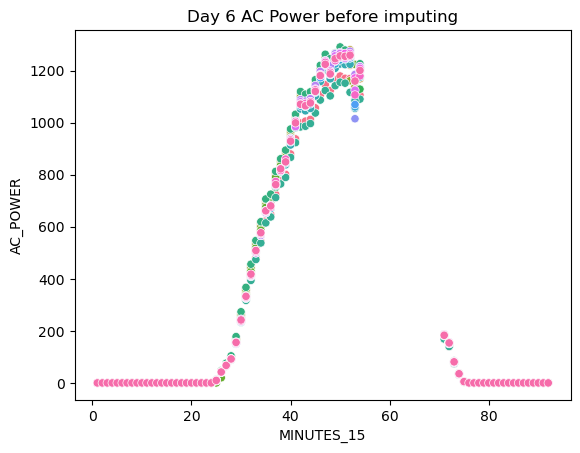

In [31]:
sns.scatterplot(data=df[~df.isna()][df.DAY == 6], x='MINUTES_15', y='AC_POWER', hue='INVERTER', legend=False);
plt.title('Day 6 AC Power before imputing');

Now we can impute the other missing values. Let's try a couple of different methods and see what is more effective. We'll pick sklearn KNNImputer and also, based on this <a href="https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460">article</a>, the built-in pandas method interpolate, with the time method specially. For best results we will apply our imputer to each inverter individually and then concatenate the results.

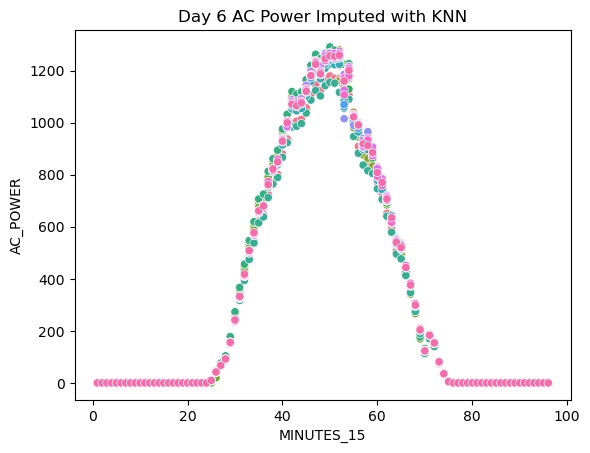

In [32]:
imputer = KNNImputer(n_neighbors=10)
inverter_dfs = []
inverter_df = None
for i in inverters:
    inverter_df = df[df.INVERTER == i]
    inverter_df.pop('INVERTER')
    inverter_df.index = inverter_df['DATE_TIME']
    datetime = inverter_df.pop('DATE_TIME')
    inverter_df = pd.DataFrame(imputer.fit_transform(inverter_df), columns=inverter_df.columns, index=datetime)
    inverter_df['INVERTER'] = i
    inverter_df = inverter_df.reset_index()
    inverter_dfs.append(inverter_df)
df_knn = pd.concat(inverter_dfs)

sns.scatterplot(data=df_knn[df_knn.DAY == 6], x='MINUTES_15', y='AC_POWER', hue='INVERTER', legend=False);
plt.title('Day 6 AC Power Imputed with KNN');

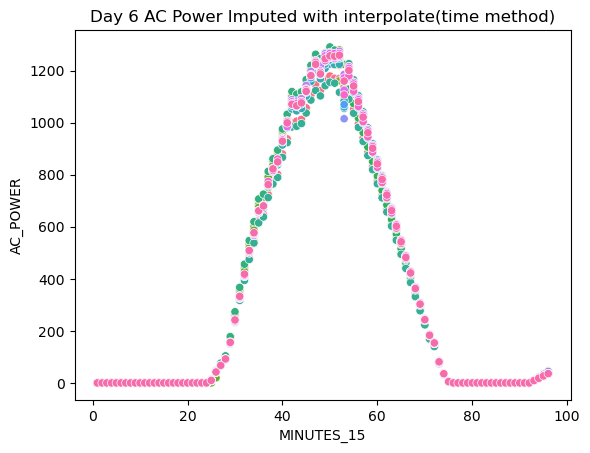

In [33]:
inverter_dfs = []
inverter_df = None
for i in inverters:
    inverter_df = df[df.INVERTER == i]
    inverter_df.pop('INVERTER')
    inverter_df.index = inverter_df['DATE_TIME']
    datetime = inverter_df.pop('DATE_TIME')
    inverter_df = inverter_df.interpolate(method='time')
    inverter_df['INVERTER'] = i
    inverter_df = inverter_df.reset_index()
    inverter_dfs.append(inverter_df)
df_interpolate = pd.concat(inverter_dfs)
sns.scatterplot(data=df_interpolate[df_interpolate.DAY == 6], x='MINUTES_15', y='AC_POWER', hue='INVERTER', legend=False);

plt.title('Day 6 AC Power Imputed with interpolate(time method)');

Both imputation methods seem to work pretty well, however, the KNNImputer appears to capture a bit more of the nuance of the data though, so we will choose that. Let's also make an imputer function.

In [34]:
def imputer(df, imputer=KNNImputer(n_neighbors=10)):
    imputer = imputer
    inverter_dfs = []
    inverter_df = None
    for i in inverters:
        inverter_df = df[df.INVERTER == i]
        inverter_df.pop('INVERTER')
        inverter_df.index = inverter_df['DATE_TIME']
        datetime = inverter_df.pop('DATE_TIME')
        inverter_df = pd.DataFrame(imputer.fit_transform(inverter_df), columns=inverter_df.columns, index=datetime)
        inverter_df['INVERTER'] = i
        inverter_df = inverter_df.reset_index()
        inverter_dfs.append(inverter_df)
    df = pd.concat(inverter_dfs)
    return df

df = imputer(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71808 entries, 0 to 3263
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            71808 non-null  datetime64[ns]
 1   DC_POWER             71808 non-null  float64       
 2   AC_POWER             71808 non-null  float64       
 3   DAILY_YIELD          71808 non-null  float64       
 4   TOTAL_YIELD          71808 non-null  float64       
 5   AMBIENT_TEMPERATURE  71808 non-null  float64       
 6   MODULE_TEMPERATURE   71808 non-null  float64       
 7   IRRADIATION          71808 non-null  float64       
 8   HOUR                 71808 non-null  float64       
 9   DAY                  71808 non-null  float64       
 10  DAY_WEEK             71808 non-null  float64       
 11  MINUTES_15           71808 non-null  float64       
 12  INVERTER             71808 non-null  object        
dtypes: datetime64[ns](1), float64(11

## Target
Before establishing a baseline we need to create our target. As mentioned previously, our target will be the sum of the AC power generation between all the inverters for a given 15 minute interval forecasted ahead to the next day. So let's make the target and examine it a bit more closely before establishing a baseline.

In [35]:
day = 96
#shifting to day ahead and droping nulls cause by the shift
target = df.groupby('DATE_TIME').sum(numeric_only=True).AC_POWER.shift(-day)
target = target.dropna()

Looking at our target over one week.

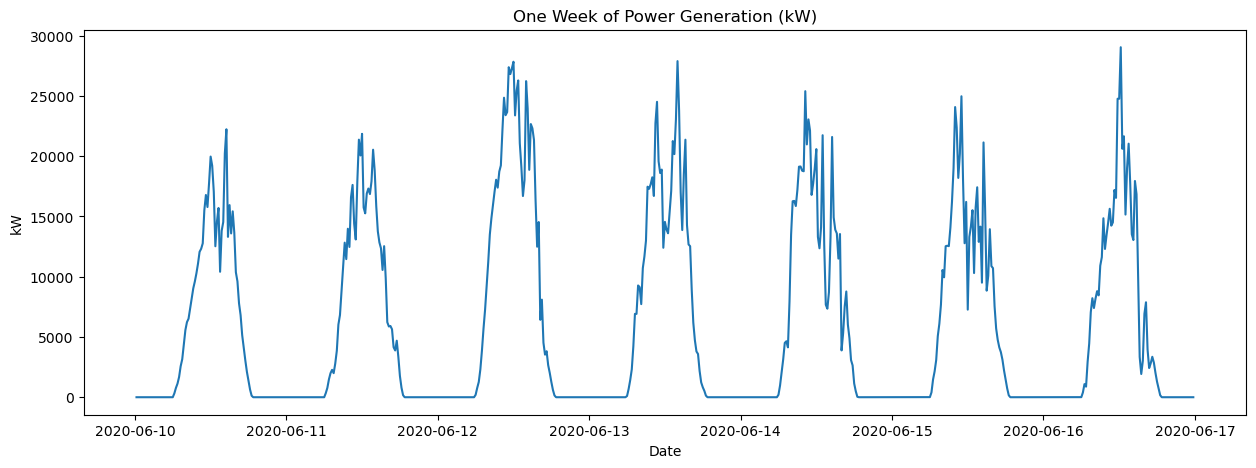

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(target[target.index > '2020-06-10'])
plt.title('One Week of Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW');

This is what we will be modeling. There are a lot valleys and sharp peaks. Modeling the inverters seperately or including all the inverter generation data in the model could help address this.

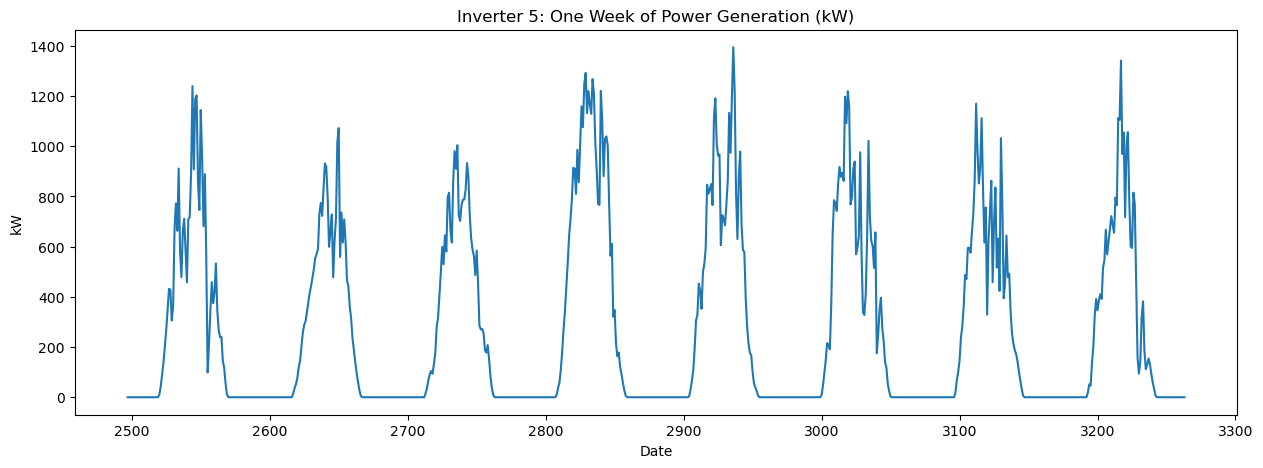

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(df[(df.INVERTER == inverters[5]) & (df.DATE_TIME > '2020-06-10')].AC_POWER)
plt.title('Inverter 5: One Week of Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW');

However, looking at just one inverter actually doesn't seem to smooth out the data any, so the difference between including the inverter data seperately or just aggregating might be neglible. Either way, we'll explore both to compare the results. Let's look at the houlry results.

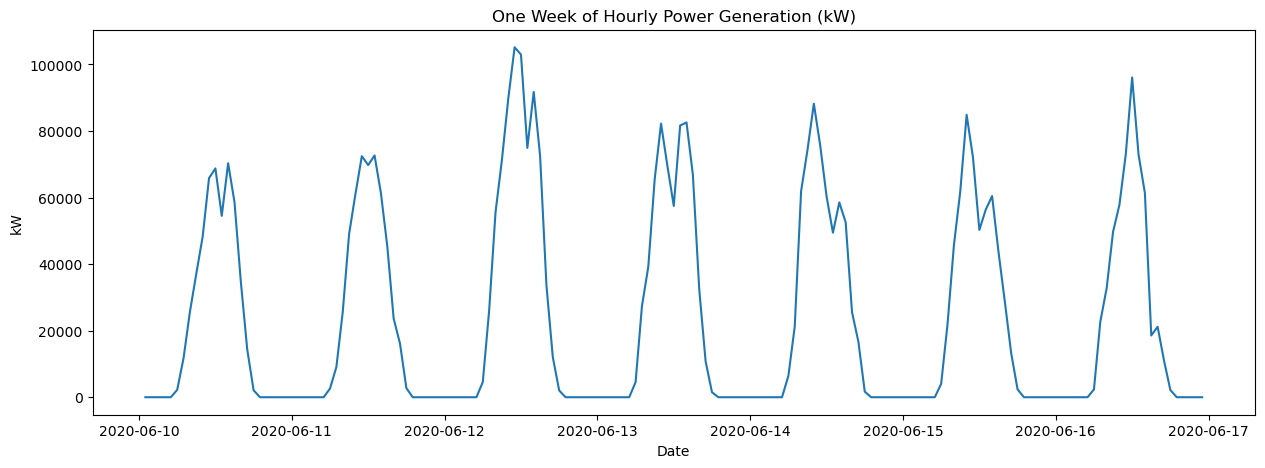

In [38]:
target_hour = target.resample('H').sum()

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(target_hour[target_hour.index > '2020-06-10'])
plt.title('One Week of Hourly Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW');

This is much smoother and might be easier for the model to handle. Some of the features we make later might be able to take advantage of this, but are ultimate goal is the 15 min AC power generation.

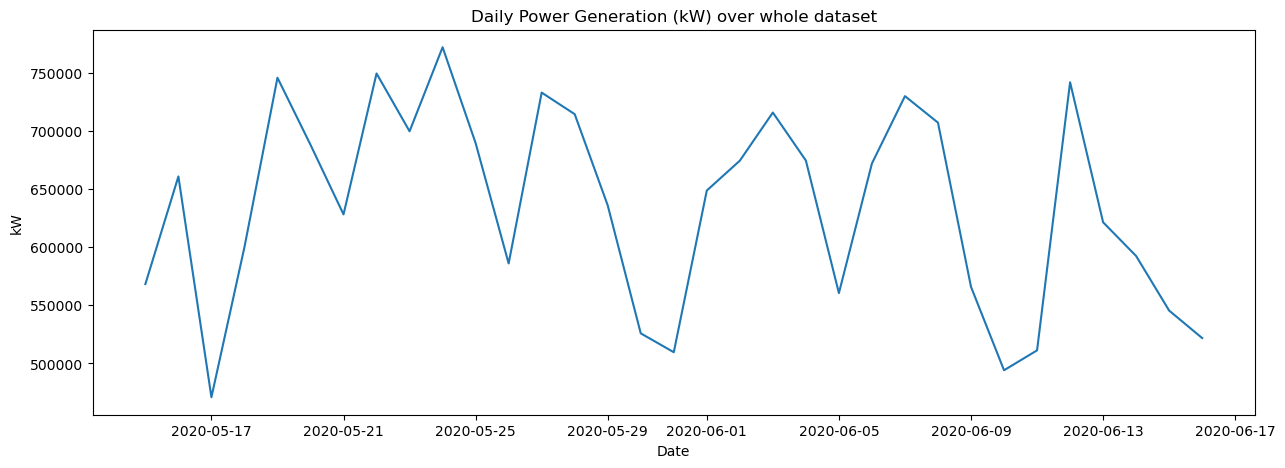

In [39]:
target_day = target.resample('D').sum()
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(target_day)
plt.title('Daily Power Generation (kW) over whole dataset')
plt.xlabel('Date')
plt.ylabel('kW');

It looks like there might be some longer trends present in the generation, possilby due to the weather patterns. We will try to include some features that could capture this in our model.

## Time series decomposition

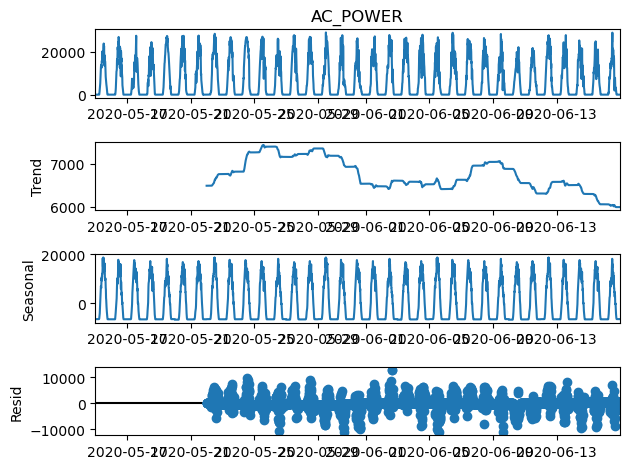

In [40]:
result_decompose=seasonal_decompose(target, model='additive', period=96*7, two_sided=False);
result_decompose.plot();

Decomposing our target captures some of the trends a bit better. Of course, the daily pattern is again clear. The residual plot does show quite a bit of noise, which will be challenging for our model to handle. Maybe some of the exogenous features can help with this. 

## Establishing Baseline
We are now ready to establish a baseline. Our baseline will be that the generation was the same as the day before at the same 15 minute interval. We will use root mean squared error (RMSE) scoring throughout and set aside the last 8 days of data to test between models. This will give us 7 days to work with since we are forecasting a day ahead. RMSE is used to give our model an extra penalty for large errors (since the errors are squared in the calculation). The smaller the score the better. 

In [41]:
day = 96
#last 3 days for testing and the rest for training
target_test = target[-3*day:]
target_train = target[:-3*day]
#moving target back a day
baseline_preds = target.shift(day)[-3*day:]
baseline_score = np.round(mean_squared_error(target_test, baseline_preds, squared=False), 4)
print('baseline_score: ', baseline_score)

baseline_score:  3699.306


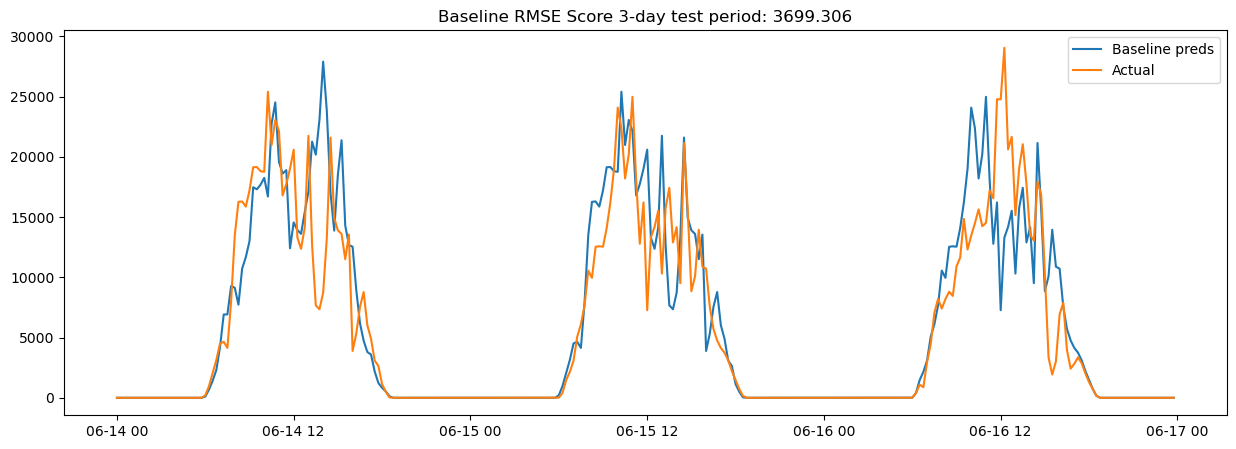

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(X[X.index > '2020-06-10'].index, y_pred[X.index > '2020-06-10'], alpha=0.5)
plt.plot(baseline_preds, label='baseline')
plt.plot(target_test);
plt.title(f'Baseline RMSE Score 3-day test period: {baseline_score}')
plt.legend(['Baseline preds', 'Actual']);

This is actually not too bad. It does capture some stretches pretty accurately. Likely the day before data will play a prominent role in our model.

## How to handle inverters? / Weather impact
So far we have had all of the inverters in one column of our dataframe with all of the their individual generation data in additional rows. For modeling though we should aggregate our dataframe to one datatime and make that our index. This leaves the question of what to do with the inverters. We could: aggregate accross them, greatly simplifying our dataframe, but possibly losing helpful information; or pivot them as new features to our dataframe making it much more complex. Also, as per our project scope, let's use this chance to see how the weather data impacts the models performance. We'll setup for each scenerio below.

In [43]:
generation = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
weather = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
all_features = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
#Aggregating data across inverters. We will sum the generation data and take the mean of the weather data. Also, adding back basic datetime features
df_agg = pd.concat([df.groupby('DATE_TIME')[generation].sum(numeric_only=True), df.groupby('DATE_TIME').mean(numeric_only=True)[weather]], axis=1)

df_agg['HOUR'] = df_agg.index.hour
df_agg['DAY'] = df_agg.index.dayofyear
df_agg['DAY_WEEK'] = df_agg.index.dayofweek
df_agg['MINUTES_15'] = df_agg.index.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df_agg['MINUTES_15'] = df_agg.MINUTES_15.map({df_agg.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df_agg['DAY'] = df_agg.DAY.map({df_agg.DAY.unique()[i-1]:i for i in range(1, 35)})
#Pivoting inverter generation data as features and adding back datatime features
inverter_dfs = []
for i in inverters:
    df_inverter = df[df.INVERTER == i][['INVERTER', 'DATE_TIME', 'AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
    df_inverter.pop('INVERTER')
    date_time = df_inverter.pop('DATE_TIME')
    df_inverter.index = date_time
    df_inverter.columns += f'_{i}'
    inverter_dfs.append(df_inverter)
    
df_sep = pd.concat(inverter_dfs, axis=1, ignore_index=False)
df_sep = pd.concat([df_sep, df_agg], axis=1)

all_features_seperated = list(df_sep.columns)

#Without the weather data
df_agg_no_weather = df_agg.drop(weather, axis=1)
df_sep_no_weather = df_sep.drop(weather, axis=1)

#For deep learning model
df_agg_dl = df_agg.copy()
df_sep_dl = df_sep.copy()

## Model Selection
Finally, we have made it to selecting our model. Per the project scope were are going to use an XGBoost algorithm. XGBoost is chosen since it is known to have generally good results and is quick to train. 

### CV
We'll use GridSearchCV to both help tune our model and handle the cross-validation for us. Since we are of course using time series data the CV needs to be sensitive to target leakage by only testing on future indices. Luckily, sklearn has a function to help us. We'll leave off the last 4 days for future use (to have 3 days of day ahead testing). Setting the test size to 96 will have it test one day ahead for a full day at a time. Also, let's have no limit on the train size to make it an expanding training window. This might help the model capture some longer term trends.

In [44]:
day = 96
tscv = TimeSeriesSplit(test_size=day, n_splits=29)
cv_indices = []
#since all our inverter splits share the same index we'll just choose df_agg
for train_indices, test_indices in tscv.split(df_agg.iloc[:-day*4]):
    cv_indices.append((train_indices, test_indices))

### GridSearch
Now with our CV indices in place we are ready to train and test our first models. Let's start with a very basic grid search for our XGBoost regressor and the data aggregated across the inverters.

In [45]:
#making train and test sets for our different inverter splits and with and without the weather data
df_agg_no_weather_train = df_agg_no_weather.iloc[:-day*4]
df_agg_no_weather_test = df_agg_no_weather.iloc[-day*4:-day]

df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

df_sep_no_weather_train = df_sep_no_weather.iloc[:-day*4]
df_sep_no_weather_test = df_sep_no_weather.iloc[-day*4:-day]

df_sep_train = df_sep.iloc[:-day*4]
df_sep_test = df_sep.iloc[-day*4:-day]

Let's train it now with the first scenario of aggregated generation data and no weather data.

In [46]:
xgb = XGBRegressor(random_state=1)
param_grid = {}
gs = GridSearchCV(xgb, param_grid=param_grid, cv=cv_indices, verbose=10, scoring='neg_root_mean_squared_error')
gs.fit(df_agg_no_weather_train, target_train)

Fitting 29 folds for each of 1 candidates, totalling 29 fits
[CV 1/29; 1/1] START ...........................................................
[CV 1/29; 1/1] END ........................., score=-3361.138 total time=   0.1s
[CV 2/29; 1/1] START ...........................................................
[CV 2/29; 1/1] END ........................., score=-6109.765 total time=   0.1s
[CV 3/29; 1/1] START ...........................................................
[CV 3/29; 1/1] END ........................., score=-3342.868 total time=   0.1s
[CV 4/29; 1/1] START ...........................................................
[CV 4/29; 1/1] END ........................., score=-3903.878 total time=   0.1s
[CV 5/29; 1/1] START ...........................................................
[CV 5/29; 1/1] END ........................., score=-2876.037 total time=   0.1s
[CV 6/29; 1/1] START ...........................................................
[CV 6/29; 1/1] END ........................., sc

GridSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]),
                  array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 10...
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1, ...),
             param_grid={}, scoring='neg_root_mean_squared_error', verbose=10)

In [47]:
print("CV RMSE: ", -np.round(gs.best_score_, 4), "CV RMSE STD: ",
np.round(gs.cv_results_['std_test_score'][0], 4))

CV RMSE:  3734.4712 CV RMSE STD:  1034.5082


In [48]:
best_xgb = gs.best_estimator_
pd.DataFrame(best_xgb.feature_importances_.T, index=list(best_xgb.feature_names_in_), columns=['Feature_Importance']).sort_values('Feature_Importance', ascending=False)

,Feature_Importance
AC_POWER,0.532661
MINUTES_15,0.186617
HOUR,0.167840
TOTAL_YIELD,0.041567
DAY_WEEK,0.025372
DAILY_YIELD,0.024983
DC_POWER,0.020348
DAY,0.000612


In [49]:
agg_no_weather_preds = best_xgb.predict(df_agg_no_weather_test)
agg_no_weather_score = np.round(mean_squared_error(target_test, agg_no_weather_preds, squared=False), 4)
print('RMSE 3-day test period ', agg_no_weather_score)

RMSE 3-day test period  3176.0352


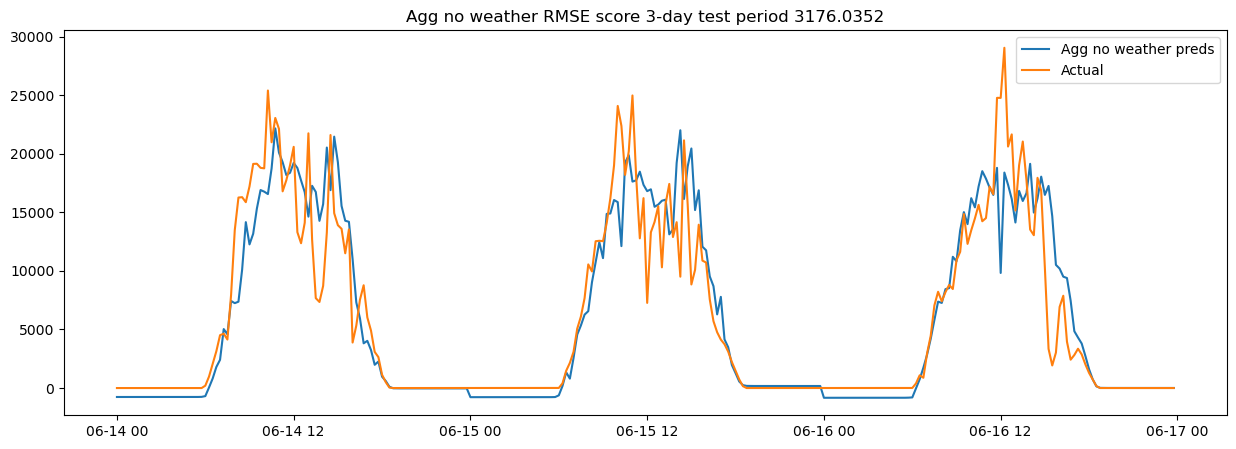

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(X[X.index > '2020-06-10'].index, y_pred[X.index > '2020-06-10'], alpha=0.5)
plt.plot(df_agg_test.index, np.array(agg_no_weather_preds), label='agg')
plt.plot(target_test.index, np.array(target_test));
plt.title(f'Agg no weather RMSE score 3-day test period {agg_no_weather_score}')
plt.legend(['Agg no weather preds', 'Actual']);

Let's streamline this a bit and make a function since we will be training our model several times. I'll comment more once each scenario has run.

In [51]:
def model_train_plot(df_train, df_test, target_train, target_test, name, results = {}, cv_indices = cv_indices, param_grid = {}, estimator=XGBRegressor(random_state=1)):
    try:
        best_rmse_score_test = results['best_rmse_score_test']
        best_rmse_score_cv = results['best_rmse_score_cv']
        best_std_cv = results['best_std_cv']
    except:
        pass
    
    gs = GridSearchCV(xgb, param_grid=param_grid, cv=cv_indices, scoring='neg_root_mean_squared_error', verbose=0)
    gs.fit(df_train, target_train);
    
    
    params_tried = gs.param_grid
    best_params = gs.best_params_
    
    rmse_score_cv = -np.round(gs.best_score_, 4)
    results.update({'rmse_score_cv':rmse_score_cv})
    
    std_cv = np.round(gs.cv_results_['std_test_score'][0], 4)
    results.update({'std_cv':std_cv})

    best_estimator = gs.best_estimator_
    feature_importances_df = pd.DataFrame(best_estimator.feature_importances_.T, index=list(best_estimator.feature_names_in_), columns=['Feature_Importance']).sort_values('Feature_Importance', ascending=False)

    model_preds = best_estimator.predict(df_test)
    rmse_score_test = np.round(mean_squared_error(target_test, model_preds, squared=False), 4)
    results.update({'rmse_score_test':rmse_score_test})
    

    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(df_test.index, np.array(model_preds), label='agg')
    plt.plot(target_test.index, np.array(target_test));
    plt.title(f'AC Power {name}_preds vs actual')
    plt.ylabel('AC Power (kW)')
    plt.xlabel('Day')
    
    
    plt.figtext(.13, .85, s=f'RMSE Score test set: {rmse_score_test}')
    try:
        rmse_score_test_difference = np.round(rmse_score_test - best_rmse_score_test, 2)
        if (rmse_score_test_difference) < 0:
            plt.figtext(.28, .85, s=f'({rmse_score_test_difference}) New Best', color='green')
            results.update({'best_rmse_score_test': rmse_score_test })
        elif (rmse_score_test_difference) == 0:
            plt.figtext(.28, .85, s=f'({rmse_score_test_difference})')
        elif (rmse_score_test_difference) > 0:
            plt.figtext(.28, .85, s=f'(+{rmse_score_test_difference})', color='red')
    except:
        results.update({'best_rmse_score_test':rmse_score_test})
    
    plt.figtext(.13, .82, s=f'CV RMSE Score: {rmse_score_cv}')
    try:
        rmse_score_cv_difference = np.round(rmse_score_cv - best_rmse_score_cv, 2)
        if (rmse_score_cv_difference) < 0:
            plt.figtext(.28, .82, s=f'({rmse_score_cv_difference}) New Best', color='green')
            results.update({'best_rmse_score_cv': rmse_score_cv })
        elif (rmse_score_cv_difference) == 0:
            plt.figtext(.28, .82, s=f'({rmse_score_cv_difference})')
        elif (rmse_score_cv_difference) > 0:
            plt.figtext(.28, .82, s=f'(+{rmse_score_cv_difference})', color='red')
    except:
        results.update({'best_rmse_score_cv':rmse_score_cv})
    
    plt.figtext(.13, .79, s=f'CV STD: {std_cv}')
    try:
        std_cv_difference = np.round(std_cv - best_std_cv, 2)
        if (std_cv_difference) < 0:
            plt.figtext(.28, .79, s=f'({std_cv_difference}) New Best', color='green')
            results.update({'best_std_cv': std_cv})
        elif (std_cv_difference) == 0:
            plt.figtext(.28, .79, s=f'({std_cv_difference})')
        elif (std_cv_difference) > 0:
            plt.figtext(.28, .79, s=f'(+{std_cv_difference})', color='red')
    except:
        results.update({'best_std_cv':std_cv})
    
    plt.figtext(.13, .76, s=f'Best Params: {best_params}')
    plt.legend([f'{name} preds', 'Actual'], loc='upper right');
    results.update({'best_params':best_params, 'params_tried':params_tried})
    return fig, gs, results, feature_importances_df.T, model_preds

Now that we have a training funtion in place let's call it with each of the four scenarios. We will also give it a basic param_grid to hopefully give each scenario a fair chance.

In [52]:
# param_grid = {'eta': [0.05, 0.1, 0.3], 'n_estimators': [50, 100, 150]}
# fig, gs_agg_no_weather, results, feat, preds = model_train_plot(df_agg_no_weather_train, df_agg_no_weather_test, target_train, target_test, 'Aggregated_no_weather_gen', results={}, param_grid=param_grid)
# feat

In [53]:
# fig, gs_agg, results, feat, preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen', results=results, param_grid=param_grid)
# feat

In [54]:
# fig, gs_sep_no_weather, results, feat, pred = model_train_plot(df_sep_no_weather_train, df_sep_no_weather_test, target_train, target_test, 'Seperated_no_weather_gen', results=results, param_grid=param_grid)
# feat

In [55]:
# fig, gs_sep, results, feat, preds = model_train_plot(df_sep_train, df_sep_test, target_train, target_test, 'Seperated_gen', results=results, param_grid=param_grid)
# feat

All of scenarios outperform the baseline on the 3 day test period. The scenarios with the inverters seperated do a bit better with the 3 day test period, but worse with the CV RSME score. To hopefully get a more robust model and not one that just performs well on our 3 day test period, let's prioitize the CV results. At the same time, we shouldn't totally discount the 3 day test period, since this is what we will ultimately compare with the deep learning model. Let's go with the aggregated generation data that includes the weather data as a nice balance of these two. Also, since it is one of the simpler scenarios it will be quicker to train and gives us more bandwidth to engineer additional features.

## Feature Engineering
Now that we have an idea of how the model is performing with just some basic datetime features, let's see how we can improve the performance with adding additional features.

### SIN/COS features
First we'll make a cosine and sine representation of the day. This technique was taken from this times series <a href="https://www.tensorflow.org/tutorials/structured_data/time_series#time">tutorial</a>. It should help the model pick out the clear daily pattern. 

In [56]:
#just using the selected dataset that doesn't include weather or seperate generation data for each inverter
timestamp_s = df_agg.index.map(pd.Timestamp.timestamp)
day_s = 24*60*60
df_agg['Day_sin'] = np.sin(timestamp_s  * (2 * np.pi / day_s))
df_agg['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day_s))


#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

Let's try our model again with this added feature. We will use the best params from the grid search as well.

In [57]:
# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train,  target_test, name='Aggregated_gen w cos/sin feature', results=results, param_grid=param_grid)
# feat

Already some improvement in the CV score and it is by far the most important feature! The cosine tracks much better with our target (see below), so has more impoartance. Removing the sine feature though does drop the score slightly, so we will leave it in for now. 

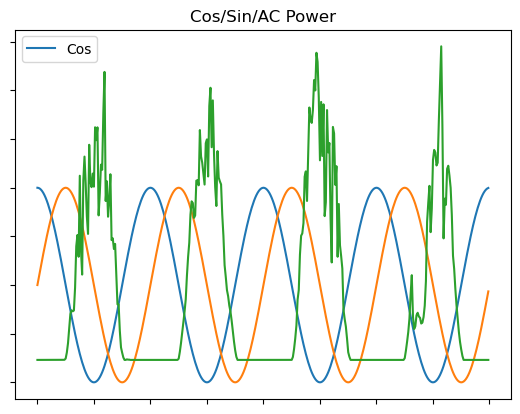

In [58]:
fig = plt.subplot()
sns.lineplot(df_agg['Day_cos'].iloc[:4*day])
sns.lineplot(df_agg['Day_sin'].iloc[:4*day])
sns.lineplot((df_agg['AC_POWER'].iloc[:4*day] - df_agg['AC_POWER'].mean())/ df_agg['AC_POWER'].std())
fig.set_ylabel('')
fig.set_xlabel('')
fig.set_yticklabels('')
fig.set_xticklabels('')
fig.legend(['Cos'])
plt.title('Cos/Sin/AC Power');


This shows how cosine does a better job of tracking with the AC power. Let's generalize the cos/sin features some and add some more frequencies to see if we can pick up on additional trends.

In [59]:
def day_cos_sin(df, freq=1, type='both'):
    timestamp_s = df.index.map(pd.Timestamp.timestamp)
    day_s = 24*60*60
    if type=='both':
        df[f'Day_sin_{freq}'] = np.sin(timestamp_s  * (2 * freq * np.pi / day_s))
        df[f'Day_cos_{freq}'] = np.cos(timestamp_s * (2 * freq * np.pi / day_s))
    elif type=='cos':
        df[f'Day_cos_{freq}'] = np.cos(timestamp_s * (2 * freq * np.pi / day_s))
    elif type=='sin':
        df[f'Day_sin_{freq}'] = np.sin(timestamp_s  * (2 * freq * np.pi / day_s))
    return df

#We will just add cos features and go up to a 'week'
df_agg = day_cos_sin(df_agg, .5, type='both')
df_agg = day_cos_sin(df_agg, 2, type='both')
df_agg = day_cos_sin(df_agg, 3, type='both')
df_agg = day_cos_sin(df_agg, 4, type='both')
df_agg = day_cos_sin(df_agg, 5, type='both')
df_agg = day_cos_sin(df_agg, 6, type='both')
df_agg = day_cos_sin(df_agg, 7, type='both')

#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

In [60]:
# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen w/ cos features ', results=results, param_grid=param_grid)
# feat

The cosine features over 1-4 days seem somewhat helpful, but not as much after that. This suggests that our data has useful information up to a period of 4 days. Let's remove the cosine features beyond 4 days and the half-day feature (0.5 frequency).

In [61]:
df_agg = df_agg.drop(['Day_sin_0.5', 'Day_sin', 'Day_sin_2', 'Day_sin_3', 'Day_sin_4', 'Day_sin_5', 'Day_sin_6', 'Day_sin_7', 'Day_cos_6', 'Day_cos_7', 'Day_cos_0.5', 'Day_cos_5', 'Day_cos_6', 'Day_cos_7'], axis=1)

#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen w cos up to 4 days', results=results, param_grid=param_grid)
# feat

### Lag, rolling, and decomposition features

Not much help, but we at least got the best CV RMSE score. Now will add a few more kinds of features. We'll focus these in on the generation and weather data ignoring the datetime features. Let's start with a lag feature. Since our cosine features were picking up some potentially useful information up to a 4 day period, we'll make a lag feature going back 4 days. This will introduce some nulls for these features at the beginning of the dataset as we shift the lag features forward, but our model should be able to handle them (see xgboost FAQ: https://xgboost.readthedocs.io/en/stable/faq.html). We'll also make lag features going back 4 15min periods, 4 30min periods, and 4 hours.

In [62]:
new_features = [df_agg]
for f in all_features:
    for i in range(0, 4, 1):
        lag_feature= df_agg[f].shift(i)
        lag_feature.name = f'lag_15{f}{i}'
        new_features.append(lag_feature)


for f in all_features:
    for i in range(0, 8, 2):
        lag_feature= df_agg[f].shift(i)
        lag_feature.name = f'lag_30{f}{i}'
        new_features.append(lag_feature)

    
for f in all_features:
    for i in range(0, 16, 4):
        lag_feature= df_agg[f].shift(i)
        lag_feature.name = f'lag_60{f}{i}'
        new_features.append(lag_feature)
    
for f in all_features:
    for i in range(0, 4*day, day):
        lag_feature= df_agg[f].shift(i)
        lag_feature.name = f'lag_day{f}{i}'
        new_features.append(lag_feature)

df_agg = pd.concat(new_features, axis=1)
    
#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]
    
#retraining with new features
# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, name='Aggregated_gen w/ lag features', results=results, param_grid=param_grid)
# feat


Definitely a noticeable improvement. Based on the feature importance the lags of a day or more were the most helpful. Now we'll add some rolling features and features based on our previous decomposition of the target. This should give our model a smoother picture of the previous generation data to work with. Similiar to when we resampled the target previously to hourly and it removed much of the noise.

In [63]:
new_features = [df_agg]
for f in all_features:
    lag_feature= df_agg[f].rolling(4).mean()
    lag_feature.name = f'rolling_{f}'
    new_features.append(lag_feature)


for f in all_features:
    lag_feature= df_agg[f].shift(day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day'
    new_features.append(lag_feature)


for f in all_features:
    lag_feature= df_agg[f].shift(2*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_2'
    new_features.append(lag_feature)

    
for f in all_features:
    lag_feature= df_agg[f].shift(3*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_3'
    new_features.append(lag_feature)
    df_agg = pd.concat(new_features, axis=1)
    
for f in all_features:
    lag_feature= df_agg[f].shift(4*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_4'
    new_features.append(lag_feature)
    
df_agg = pd.concat(new_features, axis=1)
    
#Decomposition features
df_agg['TREND'] = result_decompose.trend
df_agg['SEASONAL'] = result_decompose.seasonal
df_agg['RESIDUAL'] = result_decompose.resid

#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

#retraining with new features
# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results_decomp, feat, model_preds= model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen w more features', results= {}, param_grid=param_grid, cv_indices=cv_indices)
# feat

/tmp/ipykernel_20/2971650030.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['TREND'] = result_decompose.trend
/tmp/ipykernel_20/2971650030.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_agg['SEASONAL'] = result_decompose.seasonal
/tmp/ipykernel_20/2971650030.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

### Too good to be true?
Yes, definitely! After a quick investigation, it appears target leakage is making the results seem much better than they are in reality. Our culprit is the decomposition features, which are based on the target. But they still could be helpful. Let's try again with them based on AC Power, but not including the day ahead information from the target. Setting the two_sided parameter to False in the seasonal_decompose function is also important to avoid target leakage as it only includes past data when calculating the moving average. See documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

In [64]:
result_decompose=seasonal_decompose(df_agg.AC_POWER, model='additive', period=96*7, two_sided=False);
df_agg['TREND'] = result_decompose.trend
df_agg['SEASONAL'] = result_decompose.seasonal
df_agg['RESIDUAL'] = result_decompose.resid

#respliting with new features    
df_agg_train = df_agg.iloc[:-day*4]
df_agg_test = df_agg.iloc[-day*4:-day]

#retraining with new features
# param_grid = {'eta': [0.05], 'n_estimators': [100]}
# fig, gs_agg, results, feat, model_preds= model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen w more features', results=results, param_grid=param_grid, cv_indices=cv_indices)
# feat

Perhaps some performance gains, but it is hard to tell for sure as our test period got a fair bit worse. We might have too many features now and/or need to retune the parameters to account for the additional features the model has to process. Let's start with retuning the parameters

## Tuning parameters

Let's do some more rounds of gridsearch including some additional parameters to see if we can improve the performance

In [65]:
#1st params tried param_grid = {'booster' : ['dart', 'gbtree'], 'n_estimators': [50, 100, 150], 'eta': [0.01, 0.5, 0.1] }
#best params {'booster' : ['gbtree'], 'n_estimators': [100], 'eta': [0.1] }
# Additional parameters
# 2nd param_grid tried param_grid= {'booster' : ['gbtree'], 'max_depth': [3, 5, 10], 'colsample_bytree': [0.5, 0.75, 1], 'subsample': [0.6, 0.8, 1], 'n_estimators' : [100], 'eta' : [0.1]}
#best params {'booster' : ['gbtree'], 'max_depth':  [3], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators' : [100], 'eta' : [0.1]}
#3rd param_grid tried param_grid = {'booster' : ['gbtree'], 'max_depth': [1, 2, 3], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [100], 'eta': [0.1]}
#best params {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [100], 'eta': [0.1]}
#4th param_grid tried param_grid = {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [75, 100, 125], 'eta': [0.075, 0.1, 0.125]}
#best params {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [75], 'eta': [0.075]}
#5th tried param_grid = {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [70, 75, 80], 'eta': [0.065, 0.075, 0.085]} 
# param_grid = {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [70], 'eta': [0.065]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen tune', results=results, param_grid=param_grid)
# feat

There is a pretty big gain in performance here. Setting the the max depth to 1, the model becomes a much simpler and it is less likely to find every peak or valley, but on the average does a decent job. Depending on the exact application this could be underfitting, but since it works well with our chosen metric we'll stick with it.

### Feature selection with Random Forest

To simplfy our model even further and see if we can help it focus on the more important features, let's use a random forest to filter out some of the less helpful features.

In [66]:
# rfc = RandomForestRegressor(random_state=1)
# fig, gs_agg, results_tree, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen random forest', estimator=rfc, param_grid={})
# feat

In [67]:
# model = SelectFromModel(gs_agg.best_estimator_, prefit=True, threshold=0.005)

# df_agg_new = pd.DataFrame(model.transform(df_agg), columns=model.get_feature_names_out(df_agg.columns), index=df_agg.index)

# df_agg_train = df_agg_new.iloc[:-day*4]
# df_agg_test = df_agg_new.iloc[-day*4:-day]

# param_grid = param_grid = {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [70], 'eta': [0.065]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen feature selection', results=results, param_grid=param_grid)
# feat

Now our model is even simpler and scoring better. Also, Day_cos_2, Day_cos_3 and rolling_DAILY_YIELD_day_2 are safe to remove since they don't have any importance in our model. Let's remove a few more features and see if we can improve the score just a bit more.

In [68]:
df_agg_train = df_agg[['Day_cos', 'rolling_AC_POWER', 'lag_dayTOTAL_YIELD192']].iloc[:-day*4]
df_agg_test = df_agg[['Day_cos', 'rolling_AC_POWER', 'lag_dayTOTAL_YIELD192']].iloc[-day*4:-day]

# param_grid = param_grid = {'booster' : ['gbtree'], 'max_depth': [1], 'colsample_bytree': [1], 'subsample': [0.8], 'n_estimators': [70], 'eta': [0.065]}
# fig, gs_agg, results, feat, model_preds = model_train_plot(df_agg_train, df_agg_test, target_train, target_test, 'Aggregated_gen feature selection', results=results, param_grid=param_grid)
# feat

Although, there is always room for further tuning we will stick with this as our best XGBoost model with a RMSE score of 2926 on the 3 day test period. 

## Onto Deep learning

Now that we have completed our XGBoost model, let's move to our deep learning model. For our deep learning model we will use a LSTM layer to make a recurrent neural network model (RNN). This should allow our model to store helpful information about that past to use for its forecast. It will take in the data from the last 4 days and generate a forecast of AC Power for each 15 minute interval for the next day. 

Most of the preprocessing has already been finished before, but we additionally need to normalize the input data. Also, we'll go back check to see how it performs using the inverters seperated and aggregated. We'll include the weather data in both. My guess is that our deep learning model might be able to make better use of the additional features and show some improvement with the inverters seperated. First, we have to setup the data to feed into our deep learning model.

In [69]:
#removing features (besides basic datetime ones)
df_agg = df_agg_dl
df_sep = df_sep_dl
day = 96
tscv = TimeSeriesSplit(test_size=day, n_splits=29, max_train_size=4*day)
cv_indices = []
#since all our inverter splits share the same index we'll just choose df_agg
for train_indices, test_indices in tscv.split(df_agg.iloc[:-day*4]):
    cv_indices.append((train_indices, test_indices))

In [70]:
### df_sep full data including weather

inputs_sep_trains = []
labels_sep_trains = []
for i in range(3, len(cv_indices)-4):
    input_sep_train = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_train = pd.DataFrame(label_sep_train, columns=['AC_POWER'])
    inputs_sep_trains.append(input_sep_train)
    labels_sep_trains.append(label_sep_train)
    
inputs_sep_train_stack = tf.stack(inputs_sep_trains)
labels_sep_train_stack = tf.stack(labels_sep_trains)

inputs_sep_vals = []
labels_sep_vals = []
for i in range(len(cv_indices)-4 , len(cv_indices)):
    input_sep_val = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_val = pd.DataFrame(label_sep_val, columns=['AC_POWER'])
    inputs_sep_vals.append(input_sep_val)
    labels_sep_vals.append(label_sep_val)
    
inputs_sep_val_stack = tf.stack(inputs_sep_vals)
labels_sep_val_stack = tf.stack(labels_sep_vals)
    
val = (inputs_sep_val_stack, labels_sep_val_stack)
 

Now that our inputs and labels are ready we can setup the deep learning model. This setup is based on a model used in this tensorflow time series [tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#rnn). We have it setup from above to take in 4 days worth of data at a time. It uses a multi-output, which means that it predicts the entire day ahead forecast at once; one for each 15 minute interval for a total of 96 predictions for each batch of inputs. Having return_sequence set to False in LSTM layer enables this multi-output framework.

In [71]:
### Multi output sep
MAX_EPOCHS = 2000

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(96*1,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([96, 1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min',
                                                    restore_best_weights=True)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=inputs_sep_train_stack, y=labels_sep_train_stack, epochs=MAX_EPOCHS,
                    validation_data=val,
                    callbacks=[early_stopping],
                    verbose=0);

In order to test over the 3 day period and compare directly to our XGBoost model we need to extract the predictions from our model and then undo the normalization we applied previously.

1/1 [==============================] - 0s 468ms/step


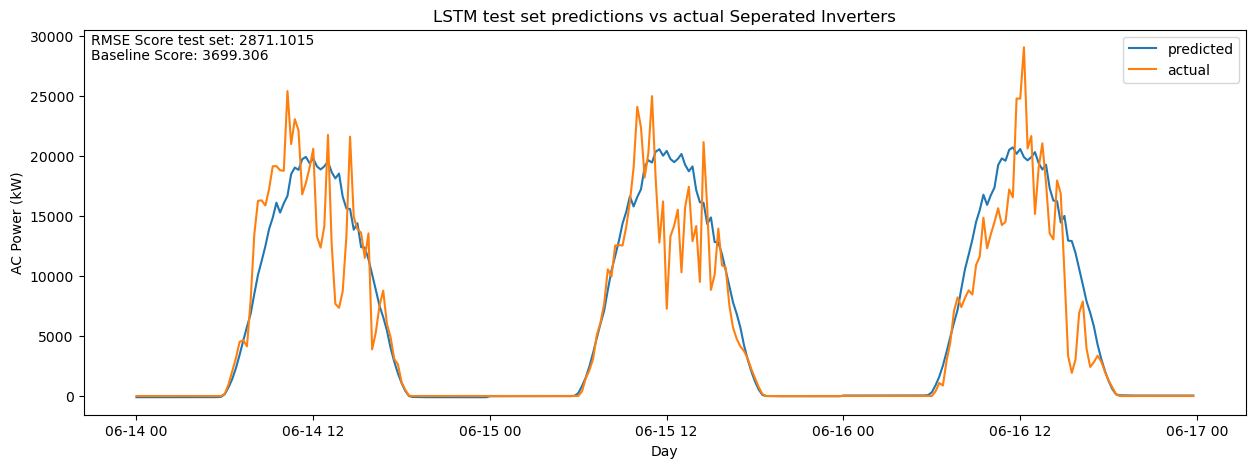

In [72]:
day_1_labels = target.iloc[-day*3:-day*2]
day_2_labels = target.iloc[-day*2:-day*1]
day_3_labels = target.iloc[-day:]

test_labels = [day_1_labels, day_2_labels, day_3_labels]
test_labels_stack = tf.stack(test_labels)

day_1_inputs = (df_sep.iloc[-day*7:-day*3] - df_sep.iloc[-day*7:-day*3].mean()) / df_sep.iloc[-day*7:-day*3].std()
day_2_inputs = (df_sep.iloc[-day*6:-day*2] - df_sep.iloc[-day*6:-day*2].mean()) / df_sep.iloc[-day*6:-day*2].std()
day_3_inputs = (df_sep.iloc[-day*5:-day] - df_sep.iloc[-day*5:-day].mean()) / df_sep.iloc[-day*5:-day].std()

test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
test_inputs_stack = tf.stack(test_inputs)

target_norm_preds = model.predict(test_inputs_stack)

labels_preds_day_1 = target_norm_preds[0] * df_sep.iloc[-day*7:-day*3].AC_POWER.std() + df_sep.iloc[-day*7:-day*3].AC_POWER.mean()
labels_preds_day_2 = target_norm_preds[1] * df_sep.iloc[-day*6:-day*2].AC_POWER.std() + df_sep.iloc[-day*6:-day*2].AC_POWER.mean()
labels_preds_day_3 = target_norm_preds[2] * df_sep.iloc[-day*5:-day].AC_POWER.std() + df_sep.iloc[-day*5:-day].AC_POWER.mean()

day_1_error = mean_squared_error(test_labels_stack[0], labels_preds_day_1, squared=False)
day_2_error = mean_squared_error(test_labels_stack[1], labels_preds_day_2, squared=False)
day_3_error = mean_squared_error(test_labels_stack[2], labels_preds_day_3, squared=False)
lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)

labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis = None)
test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis = None)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target.iloc[-3*day:].index, labels_preds)
plt.plot(target.iloc[-3*day:].index, test_labels)
plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
plt.title('LSTM test set predictions vs actual Seperated Inverters')
plt.legend(['predicted', 'actual'])
plt.ylabel('AC Power (kW)')
plt.xlabel('Day');

With no tuning is it already outperforming our XGBoost model on the 3 day test set! Let's train on the aggregated inverter data next.

In [73]:
### df_agg full data including weather
inputs_agg_trains = []
labels_agg_trains = []
for i in range(3, len(cv_indices)-4):
    input_agg_train = (df_agg.iloc[cv_indices[i][0]] - df_agg.iloc[cv_indices[i][0]].mean()) / df_agg.iloc[cv_indices[i][0]].std()
    label_agg_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_agg_train = pd.DataFrame(label_sep_train, columns=['AC_POWER'])
    inputs_agg_trains.append(input_agg_train)
    labels_agg_trains.append(label_agg_train)
    
inputs_agg_train_stack = tf.stack(inputs_agg_trains)
labels_agg_train_stack = tf.stack(labels_agg_trains)

inputs_agg_vals = []
labels_agg_vals = []
for i in range(len(cv_indices)-4 , len(cv_indices)):
    input_agg_val = (df_agg.iloc[cv_indices[i][0]] - df_agg.iloc[cv_indices[i][0]].mean()) / df_agg.iloc[cv_indices[i][0]].std()
    label_agg_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_agg_val = pd.DataFrame(label_sep_val, columns=['AC_POWER'])
    inputs_agg_vals.append(input_agg_val)
    labels_agg_vals.append(label_agg_val)
    
inputs_agg_val_stack = tf.stack(inputs_agg_vals)
labels_agg_val_stack = tf.stack(labels_agg_vals)
    
val = (inputs_agg_val_stack, labels_agg_val_stack)

In [74]:
### Multi output sep
MAX_EPOCHS = 2000

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(96*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([96, 1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min',
                                                    restore_best_weights=True)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=inputs_agg_train_stack, y=labels_agg_train_stack, epochs=MAX_EPOCHS,
                    validation_data=val,
                    callbacks=[early_stopping],
                    verbose=0);

1/1 [==============================] - 0s 448ms/step


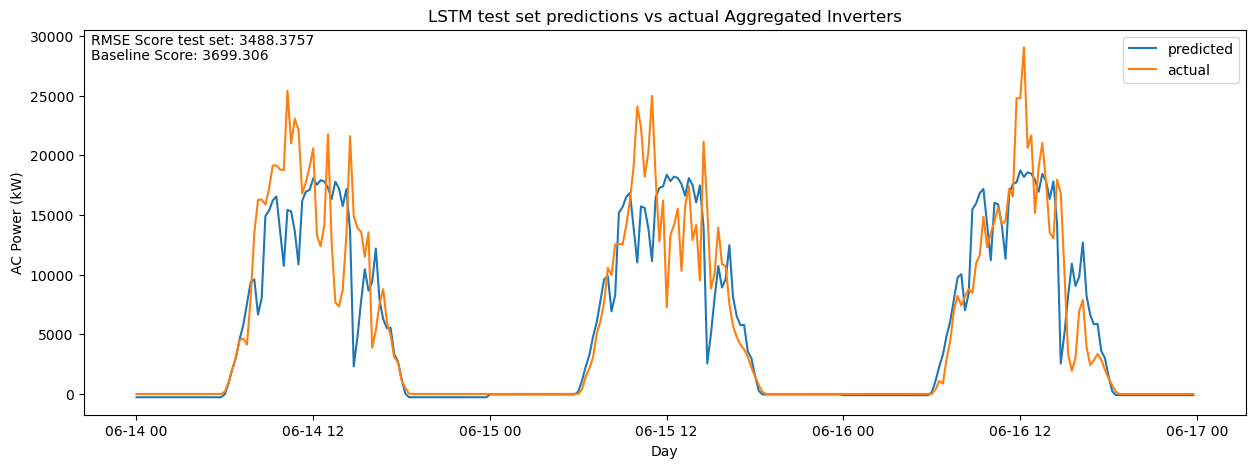

In [75]:
day_1_labels = target.iloc[-day*3:-day*2]
day_2_labels = target.iloc[-day*2:-day*1]
day_3_labels = target.iloc[-day:]

test_labels = [day_1_labels, day_2_labels, day_3_labels]
test_labels_stack = tf.stack(test_labels)

day_1_inputs = (df_agg.iloc[-day*7:-day*3] - df_agg.iloc[-day*7:-day*3].mean()) / df_agg.iloc[-day*7:-day*3].std()
day_2_inputs = (df_agg.iloc[-day*6:-day*2] - df_agg.iloc[-day*6:-day*2].mean()) / df_agg.iloc[-day*6:-day*2].std()
day_3_inputs = (df_agg.iloc[-day*5:-day] - df_agg.iloc[-day*5:-day].mean()) / df_agg.iloc[-day*5:-day].std()

test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
test_inputs_stack = tf.stack(test_inputs)

target_norm_preds = model.predict(test_inputs_stack)

labels_preds_day_1 = target_norm_preds[0] * df_agg.iloc[-day*7:-day*3].AC_POWER.std() + df_agg.iloc[-day*7:-day*3].AC_POWER.mean()
labels_preds_day_2 = target_norm_preds[1] * df_agg.iloc[-day*6:-day*2].AC_POWER.std() + df_agg.iloc[-day*6:-day*2].AC_POWER.mean()
labels_preds_day_3 = target_norm_preds[2] * df_agg.iloc[-day*5:-day].AC_POWER.std() + df_agg.iloc[-day*5:-day].AC_POWER.mean()

day_1_error = mean_squared_error(test_labels_stack[0], labels_preds_day_1, squared=False)
day_2_error = mean_squared_error(test_labels_stack[1], labels_preds_day_2, squared=False)
day_3_error = mean_squared_error(test_labels_stack[2], labels_preds_day_3, squared=False)
lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)

labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis = None)
test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis = None)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target.iloc[-3*day:].index, labels_preds)
plt.plot(target.iloc[-3*day:].index, test_labels)
plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
plt.title('LSTM test set predictions vs actual Aggregated Inverters')
plt.legend(['predicted', 'actual'])
plt.ylabel('AC Power (kW)')
plt.xlabel('Day');

The model with the inverters seperated is the clear winner in this. That shows as guessed that our deep learning model is able to do more with complex data. With this in mind, let's try to add all of the features we created during our previous feature engineering. Since this will include the seperate inverter features it could well overload it, but it will be interesting to see.

In [76]:
df_sep = df_sep_dl

df_sep = day_cos_sin(df_sep, 1, type='cos')
df_sep = day_cos_sin(df_sep, 2, type='cos')
df_sep = day_cos_sin(df_sep, 3, type='cos')
df_sep = day_cos_sin(df_sep, 4, type='cos')


result_decompose=seasonal_decompose(df_sep.AC_POWER, model='additive', period=96*7, two_sided=False);
df_sep['TREND'] = result_decompose.trend
df_sep['SEASONAL'] = result_decompose.seasonal
df_sep['RESIDUAL'] = result_decompose.resid
    

for f in all_features_seperated:
    new_features = [df_sep]
    for i in range(0, 4, 1):
        lag_feature= df_sep[f].shift(i)
        lag_feature.name = f'lag_15{f}{i}'
        new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)
    
for f in all_features_seperated:
    new_features = [df_sep]
    for i in range(0, 8, 2):
        lag_feature= df_sep[f].shift(i)
        lag_feature.name = f'lag_30{f}{i}'
        new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)
    
for f in all_features_seperated:
    new_features = [df_sep]
    for i in range(0, 16, 4):
        lag_feature= df_sep[f].shift(i)
        lag_feature.name = f'lag_60{f}{i}'
        new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)

for f in all_features_seperated:
    new_features = [df_sep]
    for i in range(0, 4*day, day):
        lag_feature= df_sep[f].shift(i)
        lag_feature.name = f'lag_day{f}{i}'
        new_features.append(lag_feature)
    df_agg = pd.concat(new_features, axis=1)
    
for f in all_features_seperated:
    new_features = [df_sep]
    lag_feature= df_sep[f].rolling(4).mean()
    lag_feature.name = f'rolling_{f}'
    new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)

for f in all_features_seperated:
    new_features = [df_sep]
    lag_feature= df_sep[f].shift(day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day'
    new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)

for f in all_features_seperated:
    new_features = [df_sep]
    lag_feature= df_sep[f].shift(2*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_2'
    new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)
    
for f in all_features_seperated:
    new_features = [df_sep]
    lag_feature= df_sep[f].shift(3*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_3'
    new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)

for f in all_features_seperated:
    new_features = [df_sep]
    lag_feature= df_sep[f].shift(4*day).rolling(5, center=True).mean()
    lag_feature.name = f'rolling_{f}_day_4'
    new_features.append(lag_feature)
    df_sep = pd.concat(new_features, axis=1)

imputer = KNNImputer(n_neighbors=10)
df_sep = pd.DataFrame(imputer.fit_transform(df_sep), columns=df_sep.columns, index=df_sep.index)
df_sep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3264 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Columns: 1789 entries, AC_POWER_INVERTER_1 to rolling_MINUTES_15_day_4
dtypes: float64(1789)
memory usage: 44.6 MB


In [77]:
### df_sep full data including all created features
inputs_sep_full_trains = []
labels_sep_full_trains = []
for i in range(4, len(cv_indices)-4):
    input_sep_full_train = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_full_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_full_train = pd.DataFrame(label_sep_full_train, columns=['AC_POWER'])
    inputs_sep_full_trains.append(input_sep_full_train)
    labels_sep_full_trains.append(label_sep_full_train)
    
inputs_sep_full_train_stack = tf.stack(inputs_sep_full_trains)
labels_sep_full_train_stack = tf.stack(labels_sep_full_trains)

inputs_sep_full_vals = []
labels_sep_full_vals = []
for i in range(len(cv_indices)-4 , len(cv_indices)):
    input_sep_full_val = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_full_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_full_val = pd.DataFrame(label_sep_full_val, columns=['AC_POWER'])
    inputs_sep_full_vals.append(input_sep_full_val)
    labels_sep_full_vals.append(label_sep_full_val)
    
inputs_sep_full_val_stack = tf.stack(inputs_sep_full_vals)
labels_sep_full_val_stack = tf.stack(labels_sep_full_vals)
    
val_full = (inputs_sep_full_val_stack, labels_sep_full_val_stack)
 

In [78]:
### Multi output sep
MAX_EPOCHS = 2000

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16,
                         return_sequences=False),
    tf.keras.layers.Dense(96*1,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([96, 1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min',
                                                    restore_best_weights=True)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=inputs_sep_full_train_stack, y=labels_sep_full_train_stack, epochs=MAX_EPOCHS,
                    validation_data=val_full,
                    callbacks=[early_stopping],
                    verbose=2);

Epoch 1/2000
1/1 - 3s - loss: 0.9896 - root_mean_squared_error: 0.9948 - val_loss: 0.9816 - val_root_mean_squared_error: 0.9908 - 3s/epoch - 3s/step
Epoch 2/2000
1/1 - 0s - loss: 0.9811 - root_mean_squared_error: 0.9905 - val_loss: 0.9519 - val_root_mean_squared_error: 0.9757 - 372ms/epoch - 372ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.9522 - root_mean_squared_error: 0.9758 - val_loss: 0.9209 - val_root_mean_squared_error: 0.9596 - 370ms/epoch - 370ms/step
Epoch 4/2000
1/1 - 0s - loss: 0.9214 - root_mean_squared_error: 0.9599 - val_loss: 0.8902 - val_root_mean_squared_error: 0.9435 - 335ms/epoch - 335ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.8914 - root_mean_squared_error: 0.9441 - val_loss: 0.8615 - val_root_mean_squared_error: 0.9282 - 349ms/epoch - 349ms/step
Epoch 6/2000
1/1 - 0s - loss: 0.8633 - root_mean_squared_error: 0.9291 - val_loss: 0.8348 - val_root_mean_squared_error: 0.9137 - 370ms/epoch - 370ms/step
Epoch 7/2000
1/1 - 0s - loss: 0.8371 - root_mean_squared_error: 0.9149 - val

1/1 [==============================] - 0s 451ms/step


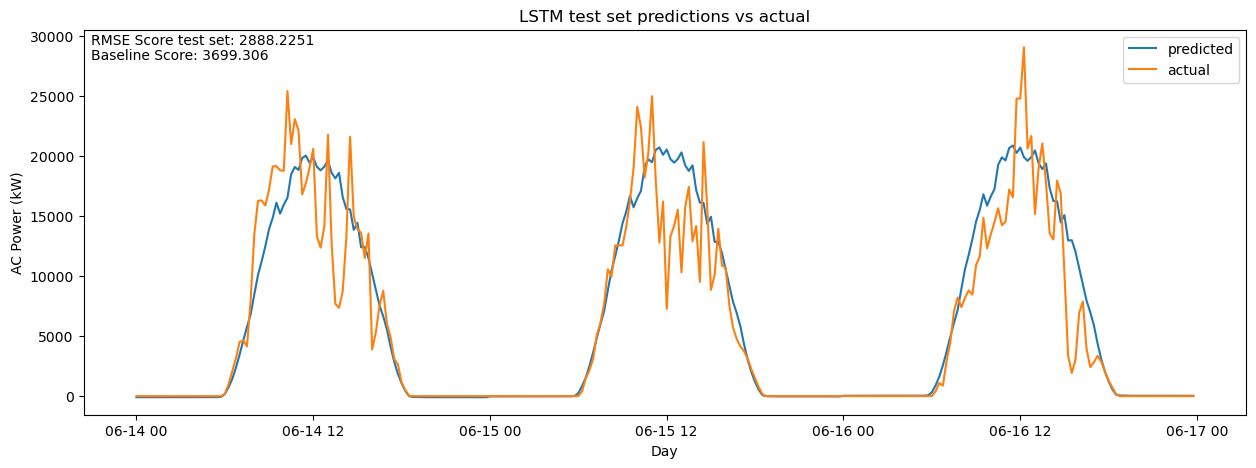

In [79]:
day_1_labels = target.iloc[-day*3:-day*2]
day_2_labels = target.iloc[-day*2:-day*1]
day_3_labels = target.iloc[-day:]

test_labels = [day_1_labels, day_2_labels, day_3_labels]
test_labels_stack = tf.stack(test_labels)

day_1_inputs = (df_sep.iloc[-day*7:-day*3] - df_sep.iloc[-day*7:-day*3].mean()) / df_sep.iloc[-day*7:-day*3].std()
day_2_inputs = (df_sep.iloc[-day*6:-day*2] - df_sep.iloc[-day*6:-day*2].mean()) / df_sep.iloc[-day*6:-day*2].std()
day_3_inputs = (df_sep.iloc[-day*5:-day] - df_sep.iloc[-day*5:-day].mean()) / df_sep.iloc[-day*5:-day].std()

test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
test_inputs_stack = tf.stack(test_inputs)

target_norm_preds = model.predict(test_inputs_stack)

labels_preds_day_1 = target_norm_preds[0] * df_sep.iloc[-day*7:-day*3].AC_POWER.std() + df_sep.iloc[-day*7:-day*3].AC_POWER.mean()
labels_preds_day_2 = target_norm_preds[1] * df_sep.iloc[-day*6:-day*2].AC_POWER.std() + df_sep.iloc[-day*6:-day*2].AC_POWER.mean()
labels_preds_day_3 = target_norm_preds[2] * df_sep.iloc[-day*5:-day].AC_POWER.std() + df_sep.iloc[-day*5:-day].AC_POWER.mean()

day_1_error = mean_squared_error(test_labels_stack[0], labels_preds_day_1, squared=False)
day_2_error = mean_squared_error(test_labels_stack[1], labels_preds_day_2, squared=False)
day_3_error = mean_squared_error(test_labels_stack[2], labels_preds_day_3, squared=False)
lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)

labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis = None)
test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis = None)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target.iloc[-3*day:].index, labels_preds)
plt.plot(target.iloc[-3*day:].index, test_labels)
plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
plt.title('LSTM test set predictions vs actual')
plt.legend(['predicted', 'actual'])
plt.ylabel('AC Power (kW)')
plt.xlabel('Day');

For all the extra features added (we now have 1690!!) there really isn't any difference. It is impressive though that the model is able to handle that many features in the first place. Since a greatly simplified model ended working best for our XGBoost model, let's try that again here. We can even use the same features. 

In [80]:
df_sep = df_sep_dl

df_sep = day_cos_sin(df_sep, 1, type='cos')
df_sep['rolling_AC_POWER'] = df_sep.AC_POWER.rolling(4).mean() 
df_sep['lag_dayTOTAL_YIELD192'] = df_sep.TOTAL_YIELD.shift(2*day)
df_sep_AC = df_sep[['AC_POWER']]
df_sep = df_sep[['Day_cos_1', 'rolling_AC_POWER', 'lag_dayTOTAL_YIELD192']]
imputer = KNNImputer(n_neighbors=10)
df_sep = pd.DataFrame(imputer.fit_transform(df_sep), columns=df_sep.columns, index=df_sep.index)
df_sep

,Day_cos_1,rolling_AC_POWER,lag_dayTOTAL_YIELD192
DATE_TIME,,,
2020-05-15 00:00:00,1.000000,218.903661,153808916.0
2020-05-15 00:15:00,0.997859,5790.360446,153808916.0
2020-05-15 00:30:00,0.991445,5790.360446,153808916.0
2020-05-15 00:45:00,0.980785,0.000000,153519480.0
2020-05-15 01:00:00,0.965926,0.000000,153519480.0
...,...,...,...
2020-06-17 22:45:00,0.946930,0.000000,155876755.0
2020-06-17 23:00:00,0.965926,0.000000,155876755.0
2020-06-17 23:15:00,0.980785,0.000000,155876755.0


In [81]:
### df_sep full data including all created features
inputs_sep_simple_trains = []
labels_sep_simple_trains = []
for i in range(4, len(cv_indices)-4):
    input_sep_simple_train = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_simple_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_simple_train = pd.DataFrame(label_sep_simple_train, columns=['AC_POWER'])
    inputs_sep_simple_trains.append(input_sep_simple_train)
    labels_sep_simple_trains.append(label_sep_simple_train)
    
inputs_sep_simple_train_stack = tf.stack(inputs_sep_simple_trains)
labels_sep_simple_train_stack = tf.stack(labels_sep_simple_trains)

inputs_sep_simple_vals = []
labels_sep_simple_vals = []
for i in range(len(cv_indices)-4 , len(cv_indices)):
    input_sep_simple_val = (df_sep.iloc[cv_indices[i][0]] - df_sep.iloc[cv_indices[i][0]].mean()) / df_sep.iloc[cv_indices[i][0]].std()
    label_sep_simple_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
    label_sep_simple_val = pd.DataFrame(label_sep_simple_val, columns=['AC_POWER'])
    inputs_sep_simple_vals.append(input_sep_simple_val)
    labels_sep_simple_vals.append(label_sep_simple_val)
    
inputs_sep_simple_val_stack = tf.stack(inputs_sep_simple_vals)
labels_sep_simple_val_stack = tf.stack(labels_sep_simple_vals)
    
val_simple = (inputs_sep_simple_val_stack, labels_sep_simple_val_stack)

In [82]:
### Multi output sep
MAX_EPOCHS = 2000

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(16,
                         return_sequences=False),
    tf.keras.layers.Dense(96*1,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([96, 1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=20,
                                                    mode='min',
                                                    restore_best_weights=True)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x=inputs_sep_simple_train_stack, y=labels_sep_simple_train_stack, epochs=MAX_EPOCHS,
                    validation_data=val_simple,
                    callbacks=[early_stopping],
                    verbose=2);

Epoch 1/2000
1/1 - 3s - loss: 0.9896 - root_mean_squared_error: 0.9948 - val_loss: 0.9823 - val_root_mean_squared_error: 0.9911 - 3s/epoch - 3s/step
Epoch 2/2000
1/1 - 0s - loss: 0.9826 - root_mean_squared_error: 0.9913 - val_loss: 0.9748 - val_root_mean_squared_error: 0.9873 - 143ms/epoch - 143ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.9754 - root_mean_squared_error: 0.9876 - val_loss: 0.9671 - val_root_mean_squared_error: 0.9834 - 147ms/epoch - 147ms/step
Epoch 4/2000
1/1 - 0s - loss: 0.9680 - root_mean_squared_error: 0.9839 - val_loss: 0.9591 - val_root_mean_squared_error: 0.9793 - 135ms/epoch - 135ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.9603 - root_mean_squared_error: 0.9799 - val_loss: 0.9508 - val_root_mean_squared_error: 0.9751 - 148ms/epoch - 148ms/step
Epoch 6/2000
1/1 - 0s - loss: 0.9523 - root_mean_squared_error: 0.9759 - val_loss: 0.9422 - val_root_mean_squared_error: 0.9707 - 137ms/epoch - 137ms/step
Epoch 7/2000
1/1 - 0s - loss: 0.9441 - root_mean_squared_error: 0.9716 - val

1/1 [==============================] - 0s 426ms/step


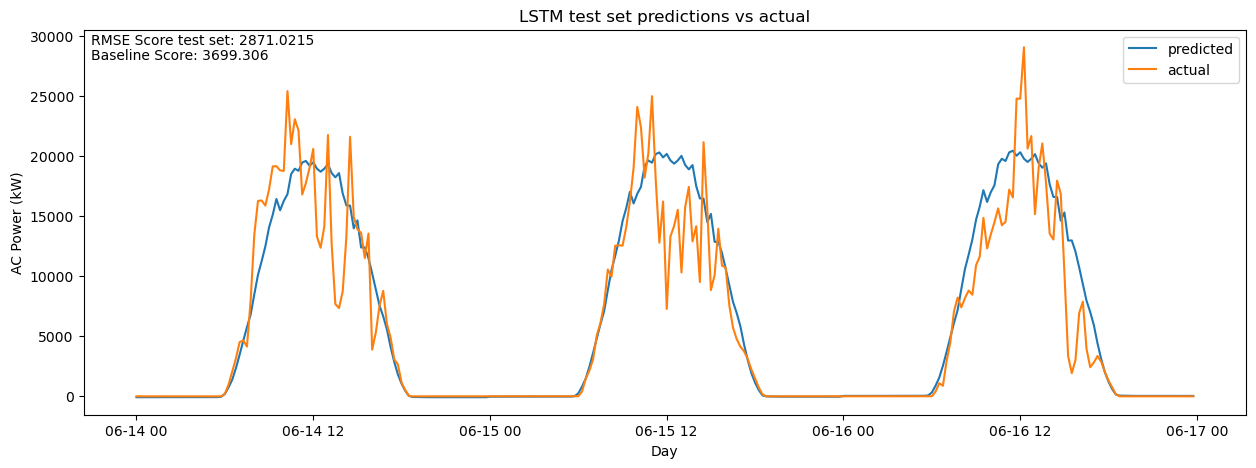

In [83]:
day_1_labels = target.iloc[-day*3:-day*2]
day_2_labels = target.iloc[-day*2:-day*1]
day_3_labels = target.iloc[-day:]

test_labels = [day_1_labels, day_2_labels, day_3_labels]
test_labels_stack = tf.stack(test_labels)

day_1_inputs = (df_sep.iloc[-day*7:-day*3] - df_sep.iloc[-day*7:-day*3].mean()) / df_sep.iloc[-day*7:-day*3].std()
day_2_inputs = (df_sep.iloc[-day*6:-day*2] - df_sep.iloc[-day*6:-day*2].mean()) / df_sep.iloc[-day*6:-day*2].std()
day_3_inputs = (df_sep.iloc[-day*5:-day] - df_sep.iloc[-day*5:-day].mean()) / df_sep.iloc[-day*5:-day].std()

test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
test_inputs_stack = tf.stack(test_inputs)

target_norm_preds = model.predict(test_inputs_stack)

labels_preds_day_1 = target_norm_preds[0] * df_sep_AC.iloc[-day*7:-day*3].AC_POWER.std() + df_sep_AC.iloc[-day*7:-day*3].AC_POWER.mean()
labels_preds_day_2 = target_norm_preds[1] * df_sep_AC.iloc[-day*6:-day*2].AC_POWER.std() + df_sep_AC.iloc[-day*6:-day*2].AC_POWER.mean()
labels_preds_day_3 = target_norm_preds[2] * df_sep_AC.iloc[-day*5:-day].AC_POWER.std() + df_sep_AC.iloc[-day*5:-day].AC_POWER.mean()

day_1_error = mean_squared_error(test_labels_stack[0], labels_preds_day_1, squared=False)
day_2_error = mean_squared_error(test_labels_stack[1], labels_preds_day_2, squared=False)
day_3_error = mean_squared_error(test_labels_stack[2], labels_preds_day_3, squared=False)
lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)

labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis = None)
test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis = None)

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target.iloc[-3*day:].index, labels_preds)
plt.plot(target.iloc[-3*day:].index, test_labels)
plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
plt.title('LSTM test set predictions vs actual')
plt.legend(['predicted', 'actual'])
plt.ylabel('AC Power (kW)')
plt.xlabel('Day');

The simplified model does just a little worse than the one with the inverters seperated. This is surprising since our deep learning model initially prefered data with the inverters seperated vs. the much simple aggregated data. Just like we found with our XGBoost model, there is enough regularity in the AC Power generation through out the daily cycle, that the model doesn't require much complexity to capture the broad strokes. Eventhough it is tempting to go with this simpler model, we will pick the initial model we tried with the inverters seperated as the score is just a bit better over our 3-day test period.

So overall the RNN/LSTM model out performed the XGBoost model with 

## Wait, wasn't there another plant?
Yes, let's not forget there is a whole other solar plant and associated weather data to model. We'll take our most successful model so far and make a full pipeline out it to process the 2nd solar plant data and make a day ahead forecast for it.

## Pipeline
To make a pipeline we'll break out the process into multiple functions based on different parts of the modeling process. Along the way we'll add in some additional parameters to increase the flexibility of our model. Specifically, let's build-in the option to change the forecast length to up to a week ahead.

In [84]:
def data_preprocessing(df_gen_csv, df_weather_csv, imputer=KNNImputer(n_neighbors=10), gen_datetime_format='%Y-%m-%d %H:%M:%S' , weather_datetime_format='%Y-%m-%d %H:%M:%S'):
    """This takes in the raw plant generation and weather data and 
    performs the basic preprocessing, joining the datasets, adding rows for missing datetimes, and imputing missing data"""
    
    df_gen = pd.read_csv(df_gen_csv)
    df_gen = df_gen.drop('PLANT_ID', axis=1)

    df_gen['INVERTER'] = df_gen.SOURCE_KEY.map({df_gen.SOURCE_KEY.unique()[i-1]: f'INVERTER_{i}' for i in range(1, len(df_gen.SOURCE_KEY.unique()) +1)})
    df_gen = df_gen.drop('SOURCE_KEY', axis=1)

    inverters = df_gen.INVERTER.unique()

    df_gen['DATE_TIME'] = pd.to_datetime(df_gen.DATE_TIME, format=gen_datetime_format)

    df_weather = pd.read_csv(df_weather_csv)

    df_weather = df_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
    df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format=weather_datetime_format)

    datetimes_full = pd.Series(pd.date_range(df_gen.DATE_TIME.min(), df_gen.DATE_TIME.max(), freq='15min'), name='DATE_TIME')

    dfs_gen = []
    for i in inverters:
        df_inverter = df_gen[df_gen.INVERTER == i]
        df_inverter = df_inverter.merge(datetimes_full, on='DATE_TIME', how='right')
        df_inverter['INVERTER'] = i
        dfs_gen.append(df_inverter)
    df_gen = pd.concat(dfs_gen)

    df = df_gen.merge(df_weather, on='DATE_TIME', how='left')

    df['HOUR'] = df.DATE_TIME.dt.hour
    df['DAY'] = df.DATE_TIME.dt.dayofyear
    df['DAY_WEEK'] = df.DATE_TIME.dt.dayofweek
    df['MINUTES_15'] = df.DATE_TIME.dt.time

    #This maps the 15 minute intervals over the course of the day to ints 1-96. 
    df['MINUTES_15'] = df.MINUTES_15.map({df.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
    #Change day of year to day of data
    df['DAY'] = df.DAY.map({df.DAY.unique()[i-1]:i for i in range(1, 35)})

    #Had a go through a few trys to settle on MINUTES_15 = 75 as a good starting point for night.
    nighttime = [i for i in range(75,97)]
    #Making these changes to the original df
    df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.HOUR.isin([0]), 0)
    #We need a maximun daily yield for each inverter seperately
    daily_yield = df.copy()
    daily_yield = df.merge(pd.DataFrame({'DAILY_YIELD_DAY_MAX' : df.groupby([ 'INVERTER', 'DAY']).max()['DAILY_YIELD']}).reset_index(), on=['INVERTER', 'DAY'], how='right')
    df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.MINUTES_15.isin(nighttime), daily_yield['DAILY_YIELD_DAY_MAX'])

    imputer = KNNImputer(n_neighbors=10)
    inverter_dfs = []
    inverter_df = None
    for i in inverters:
        inverter_df = df[df.INVERTER == i]
        inverter_df.pop('INVERTER')
        inverter_df.index = inverter_df['DATE_TIME']
        datetime = inverter_df.pop('DATE_TIME')
        inverter_df = pd.DataFrame(imputer.fit_transform(inverter_df), columns=inverter_df.columns, index=datetime)
        inverter_df['INVERTER'] = i
        inverter_df = inverter_df.reset_index()
        inverter_dfs.append(inverter_df)
    df = pd.concat(inverter_dfs)
    return df

def basic_features(df, inverters_split = True, weather_included = True):
    """This makes the basic datetime features out of the preprocessed df and
    also creates 4 different dfs for inverters being split or not and whether or not the weather data is included"""
    generation = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
    weather = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
    all_features = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
    #Aggregating data across inverters. We will sum the generation data and take the mean of the weather data. Also, adding back basic datetime features
    df_agg = pd.concat([df.groupby('DATE_TIME')[generation].sum(numeric_only=True), df.groupby('DATE_TIME').mean(numeric_only=True)[weather]], axis=1)

    df_agg['HOUR'] = df_agg.index.hour
    df_agg['DAY'] = df_agg.index.dayofyear
    df_agg['DAY_WEEK'] = df_agg.index.dayofweek
    df_agg['MINUTES_15'] = df_agg.index.time

    #This maps the 15 minute intervals over the course of the day to ints 1-96. 
    df_agg['MINUTES_15'] = df_agg.MINUTES_15.map({df_agg.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
    #Change day of year to day of data
    df_agg['DAY'] = df_agg.DAY.map({df_agg.DAY.unique()[i-1]:i for i in range(1, 35)})
    #Pivoting inverter generation data as features and adding back datatime features
    inverter_dfs = []
    for i in inverters:
        df_inverter = df[df.INVERTER == i][['INVERTER', 'DATE_TIME', 'AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']]
        df_inverter.pop('INVERTER')
        date_time = df_inverter.pop('DATE_TIME')
        df_inverter.index = date_time
        df_inverter.columns += f'_{i}'
        inverter_dfs.append(df_inverter)
    
    df_sep = pd.concat(inverter_dfs, axis=1, ignore_index=False)
    df_sep = pd.concat([df_sep, df_agg], axis=1)

    all_features_seperated = list(df_sep.columns)

    #Without the weather data
    df_agg_no_weather = df_agg.drop(weather, axis=1)
    df_sep_no_weather = df_sep.drop(weather, axis=1)
    
    if inverters_split == True & weather_included == True:
        return df_sep
    elif inverters_split == True & weather_included == False:
        return df_sep_no_weather
    elif inverters_split == False & weather_included == True:
        return df_agg
    else:
        return df_agg_no_weather


def target_cv_baseline(df, forecast_length_days = 1, test_size=96, train_size=4*96):
    """This makes the cv indices for the model and determines the forecast length"""
    if forecast_length_days > 7:
        return print('Error forecast over 7 days ahead. Model not intended for long-term forecasts.')
    day = 96
    forecast_length = forecast_length_days * day
    #shifting to day ahead and droping nulls cause by the shift
    target = df.groupby('DATE_TIME').sum(numeric_only=True).AC_POWER.shift(-forecast_length)
    target = target.dropna()

    #last 3 days for testing and the rest for training
    target_test = target[-3*day:]
    target_train = target[:-3*day]
    #moving target back forecast length
    baseline_preds = target.shift(forecast_length)[-3*day:]
    baseline_score = np.round(mean_squared_error(target_test, baseline_preds, squared=False), 4)
    
    n_splits = len(df.iloc[:-day*(3 + forecast_length_days)]) // (day) - 1
    tscv = TimeSeriesSplit(test_size=test_size, n_splits=n_splits, max_train_size=train_size)
    cv_indices = []
    for train_indices, test_indices in tscv.split(df.iloc[:-day*(3 + forecast_length_days)]):
        cv_indices.append((train_indices, test_indices))

    return target, cv_indices, baseline_score, forecast_length_days

def inputs_labels_creation(df, target, cv_indices):
    """This makes the inputs and labels for our deep learning model"""  
    inputs_trains = []
    labels_trains = []
    for i in range(4, len(cv_indices)-4):
        input_train = (df.iloc[cv_indices[i][0]] - df.iloc[cv_indices[i][0]].mean()) / df.iloc[cv_indices[i][0]].std()
        label_train = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
        label_train = pd.DataFrame(label_train, columns=['AC_POWER'])
        inputs_trains.append(input_train)
        labels_trains.append(label_train)
    
    inputs_train_stack = tf.stack(inputs_trains)
    labels_train_stack = tf.stack(labels_trains)

    inputs_vals = []
    labels_vals = []
    for i in range(len(cv_indices)-4 , len(cv_indices)):
        input_val = (df.iloc[cv_indices[i][0]] - df.iloc[cv_indices[i][0]].mean()) / df.iloc[cv_indices[i][0]].std()
        label_val = (target.iloc[cv_indices[i][1]] - target.iloc[cv_indices[i][1]].mean()) / target.iloc[cv_indices[i][1]].std()
        label_val = pd.DataFrame(label_val, columns=['AC_POWER'])
        inputs_vals.append(input_val)
        labels_vals.append(label_val)
    
    inputs_val_stack = tf.stack(inputs_vals)
    labels_val_stack = tf.stack(labels_vals)
    
    val_stack = (inputs_val_stack, labels_val_stack)
    
    return inputs_train_stack, labels_train_stack, val_stack


def model_train(df, target, inputs_train_stack, labels_train_stack, val_stack, baseline_score, forecast_length_days, lstm_units = 16, verbose=2):
    """This trains our deep learning model and outputs the predictions and results"""
    MAX_EPOCHS = 2000

    model = tf.keras.Sequential([
  
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(96*1,
                              kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([96, 1])
    ])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=20,
                                                        mode='min',
                                                        restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(x=inputs_train_stack, y=labels_train_stack, epochs=MAX_EPOCHS,
                        validation_data=val_stack,
                        callbacks=[early_stopping],
                        verbose=verbose);
 
    day_1_labels = target.iloc[-day*3:-day*2]
    day_2_labels = target.iloc[-day*2:-day*1]
    day_3_labels = target.iloc[-day:]

    test_labels = [day_1_labels, day_2_labels, day_3_labels]
    test_labels_stack = tf.stack(test_labels)

    day_1_inputs = (df.iloc[-day*7:-day*3] - df.iloc[-day*7:-day*3].mean()) / df.iloc[-day*7:-day*3].std()
    day_2_inputs = (df.iloc[-day*6:-day*2] - df.iloc[-day*6:-day*2].mean()) / df.iloc[-day*6:-day*2].std()
    day_3_inputs = (df.iloc[-day*5:-day] - df.iloc[-day*5:-day].mean()) / df.iloc[-day*5:-day].std()

    test_inputs = [day_1_inputs, day_2_inputs, day_3_inputs]
    test_inputs_stack = tf.stack(test_inputs)

    target_norm_preds = model.predict(test_inputs_stack)

    labels_preds_day_1 = target_norm_preds[0] * df.iloc[-day*7:-day*3].AC_POWER.std() + df.iloc[-day*7:-day*3].AC_POWER.mean()
    labels_preds_day_2 = target_norm_preds[1] * df.iloc[-day*6:-day*2].AC_POWER.std() + df.iloc[-day*6:-day*2].AC_POWER.mean()
    labels_preds_day_3 = target_norm_preds[2] * df.iloc[-day*5:-day].AC_POWER.std() + df.iloc[-day*5:-day].AC_POWER.mean()

    day_1_error = mean_squared_error(test_labels_stack[0], labels_preds_day_1, squared=False)
    day_2_error = mean_squared_error(test_labels_stack[1], labels_preds_day_2, squared=False)
    day_3_error = mean_squared_error(test_labels_stack[2], labels_preds_day_3, squared=False)
    lstm_rsme_score_test_set = np.round((day_1_error + day_2_error + day_3_error) / 3, 4)

    labels_preds = np.concatenate([labels_preds_day_1, labels_preds_day_2, labels_preds_day_3], axis = None)
    test_labels = np.concatenate([test_labels_stack[0], test_labels_stack[1], test_labels_stack[2]], axis = None)

    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(target.iloc[-3*day:].index, labels_preds)
    plt.plot(target.iloc[-3*day:].index, test_labels)
    plt.figtext(.13, .85, s=f'RMSE Score test set: {lstm_rsme_score_test_set}')
    plt.figtext(.13, .82, s=f'Baseline Score: {baseline_score}')
    plt.title(f'LSTM test set predictions vs actual {forecast_length_days} day ahead forecast')
    plt.legend(['predicted', 'actual'])
    plt.ylabel('AC Power (kW)')
    plt.xlabel('Day')
    
    score_results = {'baseline_score' : baseline_score, 'model_score' : lstm_rsme_score_test_set}
    predictions = pd.Series(labels_preds, index=target.iloc[-3*day:].index, name='AC Power Generation Predictions')
   

    return predictions, score_results, fig

1/1 [==============================] - 1s 930ms/step


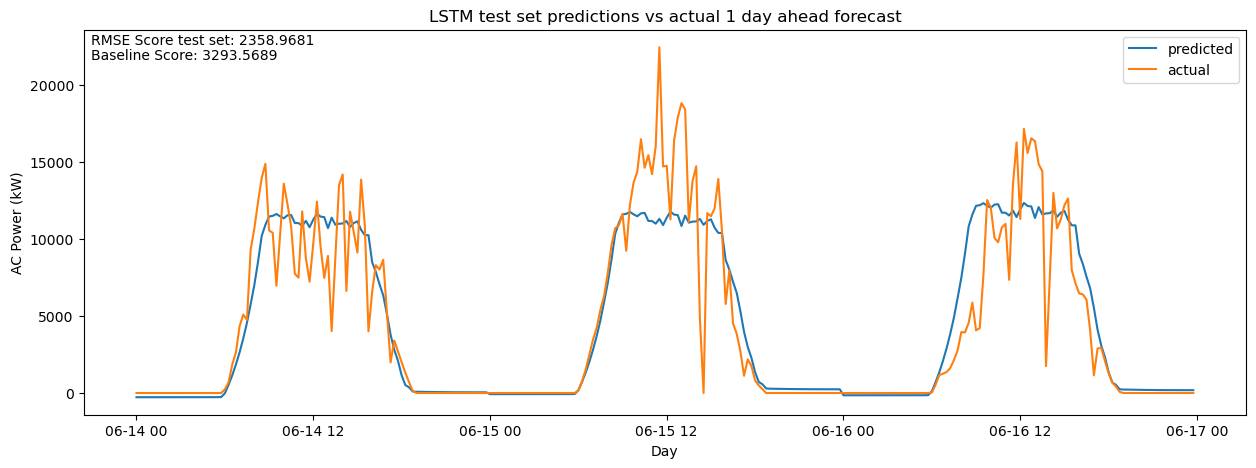

In [85]:
df = data_preprocessing('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv', '/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv', imputer=KNNImputer(n_neighbors=10))
df = basic_features(df)
target, cv_indices, baseline_score, forecast_length_days = target_cv_baseline(df, forecast_length_days = 1)
inputs_train_stack, labels_train_stack, val_stack = inputs_labels_creation(df, target=target, cv_indices=cv_indices)
predictions, score_results, fig =  model_train(df, target=target, inputs_train_stack=inputs_train_stack, labels_train_stack=labels_train_stack, val_stack=val_stack, lstm_units = 16, verbose=0, forecast_length_days=forecast_length_days, baseline_score = baseline_score)

Here are the predictions generated from our model for the last 3 days of our data.

In [86]:
predictions

DATE_TIME
2020-06-14 00:00:00   -272.780762
2020-06-14 00:15:00   -272.780762
2020-06-14 00:30:00   -272.780762
2020-06-14 00:45:00   -272.780762
2020-06-14 01:00:00   -272.780762
                          ...    
2020-06-16 22:45:00    187.192871
2020-06-16 23:00:00    181.568359
2020-06-16 23:15:00    181.962891
2020-06-16 23:30:00    183.325684
2020-06-16 23:45:00    183.325684
Name: AC Power Generation Predictions, Length: 288, dtype: float32

1/1 [==============================] - 0s 442ms/step


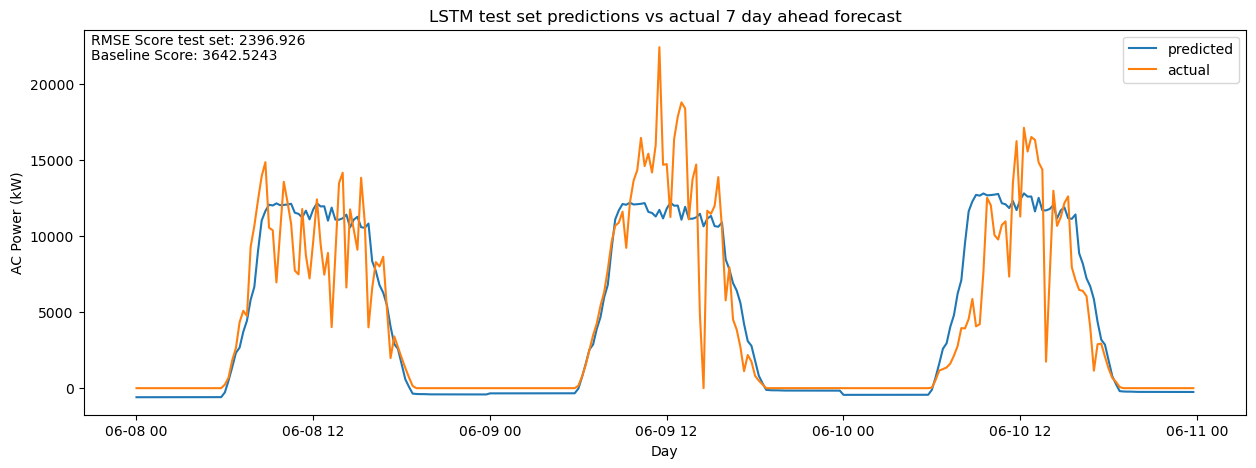

In [87]:
df = data_preprocessing('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv', '/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv', imputer=KNNImputer(n_neighbors=10))
df = basic_features(df)
target, cv_indices, baseline_score, forecast_length_days = target_cv_baseline(df, forecast_length_days = 7)
inputs_train_stack, labels_train_stack, val_stack = inputs_labels_creation(df, target=target, cv_indices=cv_indices)
predictions, score_results, fig =  model_train(df, target=target, inputs_train_stack=inputs_train_stack, labels_train_stack=labels_train_stack, val_stack=val_stack, lstm_units = 32, verbose=0, forecast_length_days=forecast_length_days, baseline_score = baseline_score)

## Conclusions

From a baseline model with a RMSE of 3699 over our test period of the last 3 days, we were able to come up with model that had a RMSE of 2878 for a ~22% improvement in performance. It was interesting comparing the XGBoost model with the RNN/LSTM one. They were able to make different use of our data. The XGBoost perfered the simpler data where the inverters were aggrigated, whereas the deep learning model did better with the inverters seperated. Ultimately, our RNN/LSTM model prevailed. Another take away was that the both models settled on a simpler prediction, that was more of an average of what was expected than a model that was able to pickup more nuanced movement. There is good and bad to this. This simpler model is less likely to be completely wrong, but also less likely to be completely accurate. There were seemingly stretches in the models that did not score as well, that appeared to match the actual data almost exactly. Of course, this could always be coincendence.



## Project Extensions
There are many further explorations that would be possible with this project. There is always more room with fine-tuning the model. Also, trying different kinds of models. ARMA (Autoregressive Moving Average) in particular would likely perform well. Using [pycaret's](https://pycaret.gitbook.io/docs/get-started/quickstart#compare-models-2) compare_models function would be a good starting point.  Bringing in extra datasets; weather predictions, sunset/sunrise, etc. could help our model. A deeper exploration of the time series aspect of our data would also be interesting.